In [1]:
#loss function


#DATA Processing
boolean='or'
limits = {
            'framenumber':[],
            'conf':[1000,.31], #conf
            "rangemap":[4,4],#rangemap
            'range':[10,10],# range
            'y':[.4,.4],# y
            "wid":[1,1],# wid
            "Hgt":[1,1] # height
}

In [2]:
!nvcc --version
!echo $LD_LIBRARY_PATH
!echo $CUDA_HOME
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64:/usr/local/cuda-10.0/lib:/usr/local/cuda-10.0/efa/lib:/opt/amazon/efa/lib:/opt/amazon/efa/lib64:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/:/usr/lib64/openmpi/lib/:/usr/local/lib:/usr/lib:/usr/local/mpi/lib:/lib/::/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow

#define CUDNN_MAJOR 7
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)
Mon Mar  2 08:40:06 2020       
+-----------------------------------------------------------------------------+
| NVI

In [3]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function


from datetime import datetime
import os
import gc
import numpy as np

validation_split=0.2
import tensorflow as tf


import pandas as pd
import cv2

print(tf.__version__)
#from roi_pooling.roi_pooling_ops import roi_pooling
#print(tf.contrib.eager.num_gpus())
print(tf.test.gpu_device_name()); print(tf.test.is_gpu_available())


1.15.0
/device:GPU:0
True


In [4]:
import misc
import extract_det
import extract_gt_bbox
import imp
import TP_or_FP
import extractLocalGlobalFeatures_v2
import random
from numpy.random import seed
base_dir='/home/ubuntu/esr_data/'
model_path=base_dir+ 'models/'
local_path='/home/ubuntu/stacked_pipeline/'


seed_value= 0

import matplotlib.pyplot as plt
%matplotlib inline
def make_range_img(rangemap,thresh=45):
    #rangemap = np.genfromtxt(fname=rangeFile, delimiter=',',  dtype="uint32")#,skip_header=1)
    rangemap=np.array([255 if pix/thresh >255 else pix/50 for pix in rangemap.flatten()],dtype="uint8").reshape((512,640,1))
    return rangemap
def make_class_img(seg_GT,convert=0,thresh=23):# 9 for ground, 11 for vegitation
    if convert==1:
        convert=11
    else:
        convert=9
    flat = np.asarray(seg_GT, dtype="uint8")
    color_clean=np.array([convert*thresh if pix == 7 else pix*thresh for pix in flat.flatten()]).reshape((512, 640,1))
    return color_clean

def merge_images(color, range_path, bw, order):
    if order=="bw":
        return np.concatenate([np.asarray(cv2.imread(bw), dtype="uint8")[:,:,0].reshape([512,640,1]),
                               make_class_img(color,convert=random.randint(0,1)), make_range_img(range_path)],axis=2)
    else:
        return np.concatenate([make_class_img(color,convert=random.randint(0,1)), make_range_img(range_path),
                               np.asarray(cv2.imread(bw), dtype="uint8")[:,:,0].reshape([512,640,1])],axis=2)

def vgg1_preprocess_input(color, range_path, bw, order='bw'):
    merge = merge_images(color, range_path, bw, order)
    image_2_arr = tf.keras.preprocessing.image.img_to_array(merge)
        # prepare the image for the VGG model
    image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr) 
    return image_preprocess
def get_avi_dir(name, frmnum, base_dir):
    return base_dir+"multi_frame_captures/"+name+'/'+name+"_frame"+str(frmnum)+'.png'
def get_ARF_dir(name, base_dir):    
    return base_dir+'semantic/'+name+'/'+name+'_000000_ARF.png'
from tensorflow.python.keras.utils import Sequence

In [5]:

def make_bal_data(inputs):
    print(np.unique(inputs['labels'], return_counts=True))
    print(len(inputs))
    cats=np.unique(inputs['labels'], return_counts=True)[1]
    ratio=cats[1]/cats[0]
    print(ratio)
    random_neg=inputs[inputs['labels']==False].sample(frac=ratio,random_state=200)
    print(len(random_neg))
    all_pos=inputs[inputs['labels']==True]
    return random_neg.append(all_pos)
def data_filter(boolean, lim, di):
    #df.loc[df['channel'].isin(['sale','fullprice'])]
    frnum =(di['framenumber'].isin(lim["framenumber"]))
    conf =(di['conf']<lim['conf'][0]) & (di['conf']>lim['conf'][1])
    rangemap = (di["rangemap"]<lim["rangemap"][0]) & (di["rangemap"]>lim['rangemap'][1])
    rng = (di["range"]<lim["range"][0]) & (di["range"]>lim['range'][1])
    y = (di["y"]<lim['y'][0]) & (di["y"]>lim['y'][1])
    Hgt = ((di['Hgt']<lim['Hgt'][0]) & (di['Hgt']>lim['Hgt'][1]))
    wid = ((di['wid']<lim['wid'][0]) & (di['wid']>lim['wid'][1]))
    if boolean =='and':
        di= di[frnum & conf & rangemap & rng & y & wid & Hgt]
    else:
        di =  di[frnum | conf | rangemap | rng | y | wid | Hgt]
    #print(len(di['filename']))
    return di #[['filename','framenumber','boundboxIndex','labels']]
def find_max(feature, label,inputs):
    data=inputs[inputs['labels']==label][feature]
    return max(data),min(data)
def gauss_normalize(col,df,df1):
    return (df[col]-df1[col].mean())/df1[col].std()
def min_max_norm(col,df):
    return (df[col]-df1[col].min())/(df1[col].max()-df1[col].min())
def normalize(func, cols,df,df1):
    for col in cols:
        df[col] = func(col,df,df1)
    return df
column_names = ['conf','rangemap', 'range', 'y', 'wid', 'Hgt',]
def print_features(test_cases):
    print("min and max ", end='')
    for feature in  ['conf','rangemap','range','y', 'wid','Hgt']:
        print(' ',feature,find_max(feature,False,test_cases), end='')
    print()
    print('total length of validation data', len(test_cases['labels']))
def ratio(inputs):
    cats=np.unique(inputs['labels'], return_counts=True)[1]
    return cats[1]/cats[0]

def path_ver(test_cases,base_dir):
    count=0
    index=[]
    for i, ID in test_cases.iterrows():
        if not os.path.isfile(get_avi_dir(ID['filename'], ID['framenumber'], base_dir)):
            #print(get_avi_dir(ID['filename'], ID['framenumber'], base_dir))
            index.append(i)
            #print(i)
        count+=1
    print (index)
    return index
def clean_data_files(test_data,base_dir):
    #path_ver(test_cases_all,base_dir)
    drop_list = path_ver(test_data,base_dir)
    print('length of drop list',len(drop_list))
    print('length of data before drop',len(test_data))
    test_data = test_data.drop(drop_list, axis=0)
    print('length of data after drop',len(test_data))
    #print(len(path_ver(test_data,base_dir)))
    return test_data
def remove_files(data,filename):
    print('total length of data', len(data['labels']))
    func = data['filename'].map(lambda x: True if x[:len(filename)]== filename else False)
    print('file split',np.unique(func,return_counts =True))
    more_data = data.copy()[func]
    
    data = data[[not f for f in func]]
    print('total length of clean data', len(data['labels']), 
          np.unique(data['labels'], return_counts= True), 
          len(np.unique(data['filename'])))
    print('total length of removed data', len(more_data['labels']), 
          np.unique(more_data['labels'], return_counts= True), 
          len(np.unique(more_data['filename'])))
    return more_data, data 
def filter_train_set(inputs):
    print(np.unique(inputs['labels'], return_counts=True))
    print(len(inputs))
    rt= ratio(inputs)
    print('ratio of positive to negative',rt)

    test_cases = data_filter(boolean, limits, inputs)
    print('filtered negative',len(test_cases['filename']))
    print(len(inputs['filename']))
    print(np.unique(test_cases['labels'],return_counts=True))

    random_neg=inputs[inputs['labels']==False].sample(frac=ratio(inputs)/2,random_state=200)
    print('random negative',len(random_neg))
    all_pos=inputs[inputs['labels']==True]
    print('all possitive', len(all_pos))
    test_cases=test_cases[test_cases['labels']==False]
    print(len(test_cases))
    test_cases_all=test_cases.append(all_pos).append(random_neg)
    print(len(test_cases_all))
    print(np.unique(test_cases_all['labels'], return_counts=True))
    all_pos=0
    test_cases=0
    random_neg =0
    return test_cases_all
def means_std(test):
    names= ['labels', 'conf', 'range',  'wid', 'Hgt',]
    name0=names[0]
    tmp = test[test[name0]==True]
    means=[];std=[];fits=[]
    for name in names[1:]:
        means.append(tmp[name].mean())
        std.append(tmp[name].std())
        x=tmp[['y', 'rangemap']].to_numpy().reshape(-1, 2)
        print(x.shape)
        y = tmp[name].to_numpy()
        print(y.shape)
        fit=LinearRegression().fit(x,y)
        fits.append(fit)
    return means, std, fits
def get_normals(cols,df1):
    return {col:[df1[col].mean(), df1[col].std()] for col in cols}
        
        
def min_max_norm(col,df,stats):
    return (df[col]-stats[1])/(stats[0]-stats[1])
def find_max(feature, label,inputs):
    data=inputs[inputs['labels']==label][feature]
    return max(data),min(data)
def gauss_normalize(col,df,stats):
    print('mean and standard deviation for ',col,stats[0],stats[1])
    return (df[col]-stats[0])/stats[1]
def normalize(func, stats, cols,df):
    for col in cols:
        df[col] = func(col,df,stats[col])
        
    return df
column_names = ['conf','rangemap', 'range', 'y', 'wid', 'Hgt',]
def feature_EDA1(sample_df, subscript=''):    
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    print(ax_grid.shape)
    y = sample_df['labels'].astype(float)
    for idx, feature in enumerate(col_analysis[1:]):
        ax=ax_grid[idx//2][idx%2]
        x1 = sample_df[sample_df['labels']==1][feature].astype(float)
        x2 = sample_df[sample_df['labels']==0][feature].astype(float)
        ax.hist([x2, x1], bins=15, stacked=True, label=['False','True'])
        #ax.hist(x, bins=15, )
        ax.set_xlabel(feature)
        ax.set_ylabel('Counts')
        ax.legend(
        )
        #ax_grid[idx//2][idx%3].hist(x, y, orient='h', linewidth=.5)
        #ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
    plt.savefig("EDA1"+subscript+".jpg", format='jpg')
    display(plt.show())
def feature_EDA2(sample_df,subscript=''):
    fig, ax_grid = plt.subplots(3,2, figsize=(15,15))
    y = sample_df['labels'].astype(float)
    for idx, feature in enumerate(col_analysis[1:]):
        x = sample_df[feature].astype(float)
        sns.boxplot(x, y, ax=ax_grid[idx//2][idx%2], orient='h', linewidth=.5)
        ax_grid[idx//2][idx%2].invert_yaxis()
    fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
    plt.savefig("EDA2"+subscript+".jpg", format='jpg')
    display(plt.show())
def feature_EDA3(sample_df,subscript=''):
    corr = sample_df[col_analysis].astype(float).corr()
    fig, ax = plt.subplots(figsize=(11, 9))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
    plt.title("Correlations between features.")
    plt.savefig("EDA3"+subscript+".jpg", format='jpg')
    display(plt.show())


In [ ]:
#val_data = pd.read_pickle(base_dir+'data/final_validation_py2_pds.pkl')
val_data = pd.read_pickle(base_dir+'data/by10_py2_val_pds.pkl')
#val_data = pd.read_pickle(base_dir+'data/raw_validation_py2_pds.pkl')
print_features(val_data)
print('total number of val cases', len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
val_data = clean_data_files(val_data,base_dir)
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))

more_test_data,val_data = remove_files(val_data,"avco11")
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
print('total length of removed data', len(more_test_data['filename']),
      'total number of images',len(np.unique(more_test_data['filename'])))
test_data = pd.read_pickle(base_dir+'data/by10_py2_pds.pkl')
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
more_val_data, test_data = remove_files(test_data,"avco10")
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
print('total number of val case',len(more_val_data['filename']),
      'total number of images',len(np.unique(more_val_data['filename'])))
test_data = test_data.append(more_test_data)
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
print('test case distribution', np.unique(test_data['labels'], return_counts= True))
#test_data = make_bal_data(test_data)
print('test case distribution after balance', np.unique(test_data['labels'], return_counts= True))
#print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
stats = get_normals(column_names,test_data)
print(stats)
val_data = val_data.append(more_val_data)

val_data = make_bal_data(val_data)
print('total length of validation data', len(val_data['labels']), np.unique(val_data['labels'], return_counts= True))

print_features(val_data)

#val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())


print_features(val_data_norm)


val_data_norm = val_data_norm.sample(800)
print_features(test_data)

#test_data_norm = normalize(gauss_normalize,stats,column_names,test_data.copy())

#val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())

print_features(test_data_norm)
#print_features(val_data_norm)

inputs=0
val_inputs=0


In [53]:
#val_data = pd.read_pickle(base_dir+'data/final_validation_py2_pds.pkl')
val_data = pd.read_pickle(base_dir+'data/by10_py2_val_pds.pkl')
#val_data = pd.read_pickle(base_dir+'data/raw_validation_py2_pds.pkl')
print_features(val_data)
print('total number of val cases', len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
val_data = clean_data_files(val_data,base_dir)
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))

more_test_data,val_data = remove_files(val_data,"avco11")
print('total number of val cases',len(val_data['filename']),'total number of images',len(np.unique(val_data['filename'])))
print('total length of removed data', len(more_test_data['filename']),
      'total number of images',len(np.unique(more_test_data['filename'])))

min and max   conf (1.15, 0.0)  rangemap (32.0, 0.528)  range (5.999, 0.5)  y (0.978515625, 0.00390625)  wid (62.4, 0.7)  Hgt (11.5, 0.5)
total length of validation data 52320
total number of val cases 52320 total number of images 177
[]
length of drop list 0
length of data before drop 52320
length of data after drop 52320
total number of val cases 52320 total number of images 177
total length of data 52320
file split (array([False,  True]), array([ 1800, 50520]))
total length of clean data 1800 (array([False, True], dtype=object), array([1763,   37])) 6
total length of removed data 50520 (array([False, True], dtype=object), array([48233,  2287])) 171
total number of val cases 1800 total number of images 6
total length of removed data 50520 total number of images 171


In [54]:

test_data = pd.read_pickle(base_dir+'data/by10_py2_pds.pkl')
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
more_val_data, test_data = remove_files(test_data,"avco10")
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
print('total number of val case',len(more_val_data['filename']),
      'total number of images',len(np.unique(more_val_data['filename'])))
test_data = test_data.append(more_test_data)
print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))

total number of testcase 235980 total number of images 789
total length of data 235980
file split (array([False,  True]), array([149040,  86940]))
total length of clean data 149040 (array([False, True], dtype=object), array([137983,  11057])) 498
total length of removed data 86940 (array([False, True], dtype=object), array([78987,  7953])) 291
total number of testcase 149040 total number of images 498
total number of val case 86940 total number of images 291
total number of testcase 199560 total number of images 669


In [57]:
def filter_train_set(inputs):
    print('negative vs positive cases', np.unique(inputs['labels'], return_counts=True)[1])
    print(len(inputs))
    rt= ratio(inputs)
    print('ratio of positive to negative',rt)

    test_cases = data_filter(boolean, limits, inputs.copy())
    #print('filtered negative',len(test_cases['labels']))
    print(len(inputs['filename']))
    filtered_negative = np.unique(test_cases['labels'],return_counts=True)[1][0]
    print('filtered data set',np.unique(test_cases['labels'],return_counts=True),filtered_negative)
    print(test_cases['conf'].mean())
    all_pos=inputs[inputs['labels']==True].sample(n=10000,random_state=200)
    all_pos_count=len(all_pos)
    print('all possitive', all_pos_count)
    random_neg=inputs[inputs['labels']==False].sample(n=all_pos_count-filtered_negative,random_state=200)
    print('random negative',len(random_neg))
    
    test_cases=test_cases[test_cases['labels']==False]
    print('filtered negative', len(test_cases))
    test_cases_all=test_cases.append(all_pos).append(random_neg)
    print(len(test_cases_all))
    print(np.unique(test_cases_all['labels'], return_counts=True))
    all_pos=0
    test_cases=0
    random_neg =0
    return test_cases_all
test_data_filtered = filter_train_set(test_data)

negative vs positive cases [186216  13344]
199560
ratio of positive to negative 0.07165871890707566
199560
filtered data set (array([False, True], dtype=object), array([3151, 5846])) 3151
0.5855340669111881
all possitive 10000
random negative 6849
filtered negative 3151
20000
(array([False, True], dtype=object), array([10000, 10000]))


In [291]:
filter_train_set(val_data)

(array([False, True], dtype=object), array([7990, 7990]))
15980
ratio of positive to negative 1.0
filtered negative 5372
15980
(array([False, True], dtype=object), array([ 616, 4756]))
random negative 3995
all possitive 7990
616
12601
(array([False, True], dtype=object), array([4611, 7990]))


,filename,framenumber,boundboxIndex,bbox#,labels,conf,rangemap,range,y,wid,Hgt,range_confidence,bounding_boxes,local_object_context,global_scene_context
60991,avco10422_1038,20,572,553,False,0.55,1.01,2.62,0.798828,8.9,3.1,"[0.55, 1.01, 2.62, 0.798828125, 8.9, 3.1]","[571, 237, 394, 325, 424]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49515190...","[0.0, 0.08634393836988467, 0.0, 0.0, 0.0, 0.0,..."
82262,avco10425_1028,900,26973,26074,False,0.38,0.997,2.62,0.802734,12.1,2.9,"[0.38, 0.997, 2.62, 0.802734375, 12.1, 2.9]","[26972, 203, 397, 323, 425]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54254742...","[0.0, 0.08524045519604508, 0.0, 0.0, 0.0, 0.0,..."
86313,avco10425_1041,1800,53974,52175,False,0.39,0.943,5.999,0.830078,3.9,1.7,"[0.39, 0.943, 5.999, 0.830078125, 3.9, 1.7]","[53973, 593, 417, 631, 433]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54471544...","[0.0, 0.08520911650536003, 0.0, 0.0, 0.0, 0.0,..."
42721,avco10325_1019,900,26972,26073,False,0.5,1.13,5.999,0.654297,2.9,1.5,"[0.5, 1.13, 5.999, 0.654296875, 2.9, 1.5]","[26971, 485, 328, 513, 342]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.03308828045350137, 0.0, 0.0, 0.0, 0.00..."
23582,avco10125_1038,1260,37773,36514,False,0.49,4.934,5.999,0.304688,5.3,2.1,"[0.49, 4.934, 5.999, 0.3046875, 5.3, 2.1]","[37772, 271, 146, 323, 166]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.97727272...","[0.0019655114168573317, 0.0, 0.000156626691030..."
51540,avco13221_2001,150,4471,4322,False,0.39,0.999,5.999,0.748047,1.7,1.5,"[0.39, 0.999, 5.999, 0.748046875, 1.7, 1.5]","[4470, 361, 376, 377, 390]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07017543...","[0.0, 0.022199400313597475, 0.0, 0.0, 0.0, 0.0..."
85864,avco10425_1040,900,26975,26076,False,0.37,0.948,5.999,0.828125,3.9,1.9,"[0.37, 0.948, 5.999, 0.828125, 3.9, 1.9]","[26974, 593, 415, 631, 433]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63414634...","[0.0, 0.08521747123619261, 0.0, 0.0, 0.0, 0.0,..."
62014,avco10422_1041,60,1775,1716,False,0.38,0.993,2.62,0.804688,8.5,2.3,"[0.38, 0.993, 2.62, 0.8046875, 8.5, 2.3]","[1774, 237, 401, 321, 423]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41666666...","[0.0, 0.0863346971726327, 0.0, 0.0, 0.0, 0.0, ..."
75360,avco10425_1001,50,1471,1422,False,0.42,1.258,2.62,0.804688,8.7,3.1,"[0.42, 1.258, 2.62, 0.8046875, 8.7, 3.1]","[1470, 239, 397, 325, 427]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42415730...","[0.0, 0.08658147648708234, 0.00176740573581259..."
86824,avco10425_1043,1260,37775,36516,False,0.32,1.231,5.999,0.730469,4.5,2.7,"[0.32, 1.231, 5.999, 0.73046875, 4.5, 2.7]","[37774, 113, 361, 157, 387]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.08522608876849344, 0.0, 0.0, 0.0, 0.0,..."


In [19]:
print('test case distribution', np.unique(test_data['labels'], return_counts= True))
test_data = make_bal_data(test_data)
print('test case distribution after balance', np.unique(test_data['labels'], return_counts= True))
#print('total number of testcase',len(test_data['filename']),'total number of images',len(np.unique(test_data['filename'])))
stats = get_normals(column_names,test_data)
print(stats)

test case distribution (array([False, True], dtype=object), array([186216,  13344]))
(array([False, True], dtype=object), array([186216,  13344]))
199560
0.07165871890707566
13344
test case distribution after balance (array([False, True], dtype=object), array([13344, 13344]))
{'conf': [0.2823347571942497, 0.24505345184744076], 'rangemap': [2.6776081010191746, 3.5122556225404202], 'range': [5.29105189598273, 1.40565740548744], 'y': [0.5587779532233588, 0.19324894832090897], 'wid': [5.630077188249507, 6.164953847263076], 'Hgt': [1.92272182254194, 0.9672274628646793]}


In [212]:
#val_inputs = pd.read_pickle(base_dir+'data/by10_py2_val_pds.pkl')

val_data = val_data.append(more_val_data)

val_data = make_bal_data(val_data)
print('total length of validation data', len(val_data['labels']), np.unique(val_data['labels'], return_counts= True))

(array([False, True], dtype=object), array([80750,  7990]))
88740
0.09894736842105263
7990
total length of validation data 15980 (array([False, True], dtype=object), array([7990, 7990]))


In [21]:
#test data unbalanced avco11 all

print_features(val_data)

val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())


print_features(val_data_norm)


val_df = val_data_norm.sample(800)

min and max   conf (1.25, 0.0)  rangemap (32.0, 0.462)  range (5.999, 0.5)  y (0.978515625, 0.00390625)  wid (62.4, 0.7)  Hgt (13.3, 0.5)
total length of validation data 15980
mean and standard deviation for  conf 0.1818904590098017 0.1181622865211339
mean and standard deviation for  rangemap 2.7273172128683116 4.709290451829926
mean and standard deviation for  range 5.11838980756068 1.6430380213772784
mean and standard deviation for  y 0.6251205288353127 0.22616891888414536
mean and standard deviation for  wid 7.147089597113857 8.12325808978054
mean and standard deviation for  Hgt 1.986997394267456 1.1321398953002695
min and max   conf (9.039343875587257, -1.5393275161213953)  rangemap (6.215943375452023, -0.481031534588838)  range (0.5359645857136933, -2.8108843176308906)  y (1.5625272380848818, -2.7466827975312054)  wid (6.8018164377169095, -0.7936581019412167)  Hgt (9.992583648624162, -1.3134396203510434)
total length of validation data 15980


In [22]:
print_features(test_data)

test_data_norm = normalize(gauss_normalize,stats,column_names,test_data.copy())

#val_data_norm =  normalize(gauss_normalize,stats,column_names,val_data.copy())

print_features(test_data_norm)
#print_features(val_data_norm)

inputs=0
val_inputs=0


min and max   conf (1.38, 0.0)  rangemap (32.0, 0.419)  range (5.999, 0.5)  y (0.978515625, 0.00390625)  wid (62.4, 0.7)  Hgt (15.7, 0.5)
total length of validation data 26688
mean and standard deviation for  conf 0.1818904590098017 0.1181622865211339
mean and standard deviation for  rangemap 2.7273172128683116 4.709290451829926
mean and standard deviation for  range 5.11838980756068 1.6430380213772784
mean and standard deviation for  y 0.6251205288353127 0.22616891888414536
mean and standard deviation for  wid 7.147089597113857 8.12325808978054
mean and standard deviation for  Hgt 1.986997394267456 1.1321398953002695
min and max   conf (10.139525700324956, -1.5393275161213953)  rangemap (6.215943375452023, -0.49016242180843844)  range (0.5359645857136933, -2.8108843176308906)  y (1.5625272380848818, -2.7466827975312054)  wid (6.8018164377169095, -0.7936581019412167)  Hgt (12.112463011557013, -1.3134396203510434)
total length of validation data 26688


(array([False, True], dtype=object), array([186216,  13344]))
199560
ratio of positive to negative 0.07165871890707566
filtered negative 7080
199560
(array([False, True], dtype=object), array([1933, 5147]))
random negative 6672
all possitive 13344
1933
21949
(array([False, True], dtype=object), array([ 8605, 13344]))


In [58]:
test_data=test_data_filtered

In [59]:
#test data uneven data avco11 and avco10
#stats ={'conf': [0.1946231884058133, 0.13647004233615292], 'rangemap': [2.7810176031868936, 5.178114468979362], 'range': [5.232115700480118, 1.531472155227868], 'y': [0.6285066696595051, 0.23828253502179877], 'wid': [6.539179167726845, 6.759064059572335], 'Hgt': [1.9360327146370373, 1.056930142479502]}
#test data even avco11 and avco10
#stats ={'conf': [0.3065967911625445, 0.2605091433664969], 'rangemap': [2.698430668069409, 3.9608294617673536], 'range': [5.348067859023498, 1.329712756324813], 'y': [0.5590560375295897, 0.20504298918442823], 'wid': [5.328569174118647, 5.328334430083477], 'Hgt': [1.8996422935297, 0.9191715732966178]}
#test data unbalanced avco11 all
stats ={'conf': [0.1818904590098017, 0.1181622865211339], 'rangemap': [2.7273172128683116, 4.709290451829926], 'range': [5.11838980756068, 1.6430380213772784], 'y': [0.6251205288353127, 0.22616891888414536], 'wid': [7.147089597113857, 8.12325808978054], 'Hgt': [1.986997394267456, 1.1321398953002695]}
#test data balanced avco11 all
#stats ={'conf': [0.2823347571942497, 0.24505345184744076], 'rangemap': [2.6776081010191746, 3.5122556225404202], 'range': [5.29105189598273, 1.40565740548744], 'y': [0.5587779532233588, 0.19324894832090897], 'wid': [5.630077188249507, 6.164953847263076], 'Hgt': [1.92272182254194, 0.9672274628646793]}

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
col_analysis=['labels', 'conf',
       'rangemap', 'range', 'y', 'wid', 'Hgt']
feature_EDA1(test_data)

NameError: name 'test_data' is not defined

In [7]:
feature_EDA2(test_data)

NameError: name 'test_data' is not defined

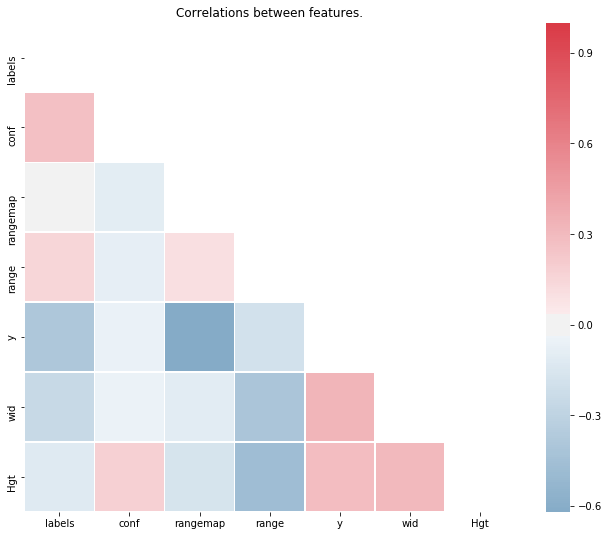

None

In [62]:
feature_EDA3(test_data)

(3, 2)


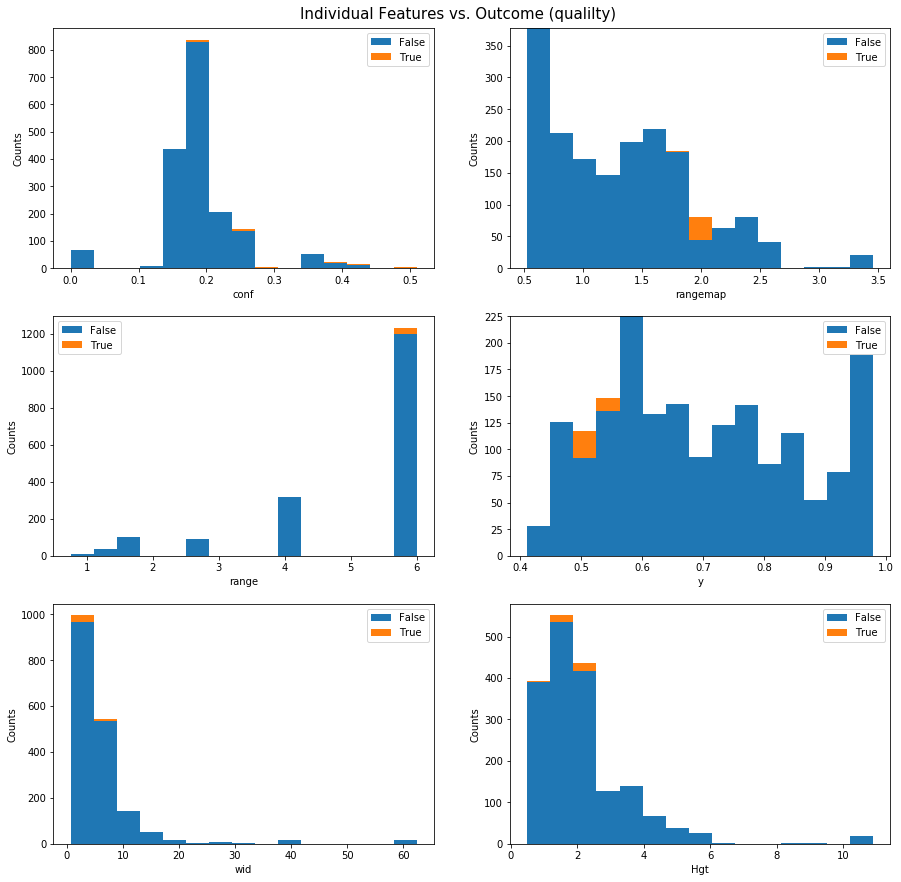

None

In [63]:
feature_EDA1(val_data)

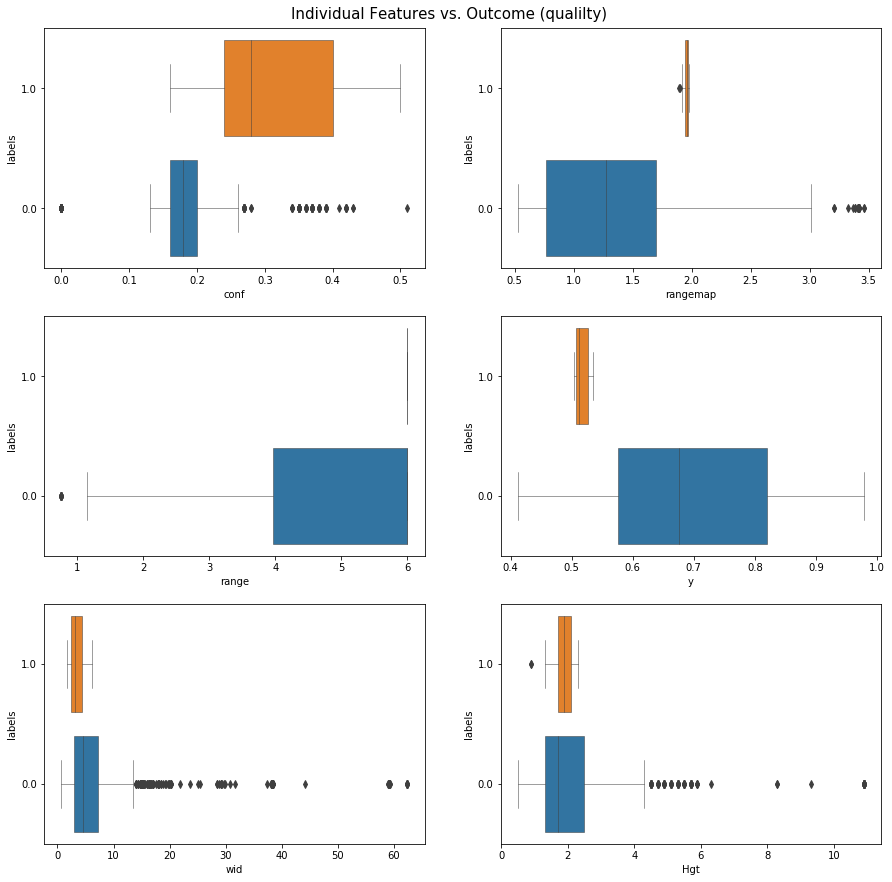

None

In [64]:
feature_EDA2(val_data)

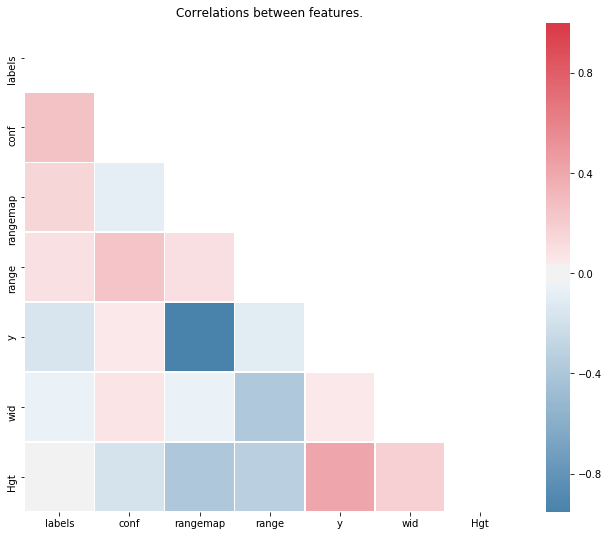

None

In [65]:
feature_EDA3(val_data)

In [109]:
#pd.DataFrame.to_pickle(test_data, 'data/test_balanced_unbiased_normed_py2_av11.pkl', protocol= 2)  
#pd.DataFrame.to_pickle(val_data,  'data/val_balanced_unbiased_normed_py2_not_av11.pkl', protocol= 2)

In [70]:
from sklearn.linear_model import LinearRegression
means, std, fits =means_std(test_cases_all_norm)
error = fits[0].predict(test_cases_all_norm[['y', 'rangemap']].to_numpy().reshape(-1, 2))-test_cases_all_norm['conf'].to_numpy()
len(error)
sum(error)
check=test_cases_all_norm[['labels', 'conf', 'range',  'wid', 'Hgt',]]
x=test_cases_all_norm[['y', 'rangemap']].to_numpy().reshape(-1, 2)
error[0]
conf1=test_cases_all_norm['conf'].to_numpy()[0]
confp1= fits[0].predict([x[0]])
print(conf1,confp1)
conf1=test_cases_all_norm['wid'].to_numpy()[0]
confp1= fits[2].predict([x[0]])
print(conf1,confp1)

(17120, 2)
(17120,)
(17120, 2)
(17120,)
(17120, 2)
(17120,)
(17120, 2)
(17120,)


In [8]:
def get_bounding_box(bbx,bb_type,dim):
    bbx  #ID['bounding_boxes']
    if bb_type ==0:
        return np.array([bbx[1]/dim[1],bbx[2]/dim[0],bbx[3]/dim[1],bbx[4]/dim[0]])
    elif bb_type==1:
        return np.array([bb for bb in bbx])[1:]
    else:
        w = bbx[3]- bbx[1]
        h = bbx[4]- bbx[2]
        return np.array([bbx[1]+w/2,w,bbx[3]+h/2,h])
def create_mask(min_pix, max_pix, box, dims):
    mask =np.zeros(dims)
    for y in range(box[2],box[4]):
        for x in range(box[1],box[3]):
            mask[y,x]=max_pix
    return mask


'''def generate_X(list_IDs,batch_size=32,image_path=base_dir,features=4,channels=3,
               bounding_box_conf=True,bounding_box_range=False, rangemap_box_range=True, stats={},
                 y_position=False,wid_included=True,hgt_icluded=True,time_of_day=False, dim=(512,640)):
        'Generates data containing batch_size images'
        # Initialization
        channel=3
        len_epoch = np.floor(len(list_IDs) // batch_size) #'Denotes the number of batches per epoch'
        
        print("length of an epoch",len_epoch)
        indexes = np.arange(len(list_IDs))
        print(indexes.shape,indexes.dtype)
        np.random.shuffle(indexes)
        index=0    
        def _load_grayscale_image(image_path,chan = False, cv2_true = False, box=[], dim=dim):
            'Load grayscale image'

            if chan:
                image_preprocess = vgg1_preprocess_input(seg_img, rangemap,image_path, order='bw')
            elif cv2_true:
                'Load grayscale image'
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255
                image_preprocess = np.stack([img,img,img], axis=2)#.reshape(512,640,3)
            else:
                # convert the image pixels to a numpy array
                image_load = tf.keras.preprocessing.image.load_img(image_path, target_size=(dim[0],dim[1]))
                # convert the image pixels to a numpy array
                image_2_arr = tf.keras.preprocessing.image.img_to_array(image_load)
                # prepare the image for the VGG model
                image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr)
            if box!=[]:
                min_pix, max_pix = [0,1]#[-123.68000030517578, 151.06100463867188]
                image_preprocess[:,:,0] = create_mask(min_pix, max_pix, box, dim)
                
            return  image_preprocess
        def normalize_batch(ID,stats,feature):
            return (ID[feature]-stats[feature][0])/float(stats[feature][1])
            
        while True:
            print('Generate one batch of data')
            print(index,len(indexes),len_epoch)
            # Generate indexes of the batch
            index+=1
            if index>= len_epoch:
                index=0
                np.random.shuffle(indexes)
            indexes_temp = indexes[index*batch_size: (index+1)*batch_size]
            print(index,len(indexes),len_epoch,batch_size,list_IDs.shape)
            # Find list of IDs
            list_IDs_temp = [list_IDs.iloc[k] for k in indexes_temp]
            print(index,len(indexes),len(list_IDs_temp),len_epoch,batch_size,list_IDs.shape)
            #generate data arrays
            local_object_features= np.empty((batch_size, 40),dtype='float32')
            globalFeatures = np.empty((batch_size, 10),dtype='float32')
            range_confidence = np.empty((batch_size, features),dtype='float32')
            bounding_boxes = np.empty((batch_size, 4),dtype='float32')
            image = np.empty((batch_size, 512, 640, channels),dtype='float32')     
            labels = np.empty((batch_size, 1), dtype=int)
            
           #['filename','framenumber','boundboxIndex','bbox#',"labels",'conf','rangemap','range','y','range_confidence',
           #        'wid','Hgt','bounding_boxes', 'local_object_context', 'global_scene_context']
            
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                #frnm = ID['framenums']
                #bboxes=ID['bboxes']
                #name = ID['filenames']
                labels[i,] = 1 if ID['labels'] else 0
                local_object_features[i,] = np.array(ID['local_object_context'].copy(),dtype='float32')
                globalFeatures[i,] = np.array(ID[ 'global_scene_context'].copy(),dtype='float32')
                hand_features=[]
                if bounding_box_conf:
                    hand_features.append(normalize_batch(ID,stats,'conf'))
                if bounding_box_range:
                     hand_features.append(normalize_batch(ID,stats,'range'))
                if rangemap_box_range:
                    hand_features.append(normalize_batch(ID,stats,'rangemap'))
                if y_position:
                    hand_features.append(normalize_batch(ID,stats,'y'))
                if wid_included:
                     hand_features.append(normalize_batch(ID,stats,'wid'))
                if hgt_icluded:
                     hand_features.append(normalize_batch(ID,stats,'Hgt'))
                if time_of_day:
                     hand_features.append(normalize_batch(ID,stats,'time'))
                range_confidence[i,] = np.array(hand_features,dtype='float32').copy()
                bounding_boxes[i,] = get_bounding_box(ID['bounding_boxes'],1,dim)
                # Store sample
                image[i,] = _load_grayscale_image(get_avi_dir(ID['filename'], ID['framenumber'], image_path),
                                                 cv2_true = True,box = ID['bounding_boxes'])


            #return X
            inpts={}
            inpts['local_object_context']=local_object_features
            inpts['global_scene_context']=globalFeatures
            inpts['range_confidence']=range_confidence
            inpts['input']=image
            inpts['bounding_boxes']=bounding_boxes.reshape((batch_size,1,4))
            
            yield inpts, {'output': labels.reshape((batch_size,1))}'''
            
def clean_up(test_data):
    for i, box in test_data['bounding_boxes'].iteritems():
        #print(box)
        box[0]=box[0] % 30
        test_data['bounding_boxes'][i]=box
        #print(box)
    return test_data
#test_data= clean_up(test_data)
#generator = generate_X(test_data,image_path=base_dir,batch_size=batch_size*steps_per_epoch,features =4)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
def gen_analysis_1(one):
    names=['range_confidence', 'global_scene_context']
    sizes = [4,10,10,5,1]
    for j,name in enumerate(names):
        tgt = one[name]
        size = sizes[j]
        print(name)
        for i in range(size):
            temp=[]
            for l in range(len(tgt)):
                temp.append(tgt[l][i])
            print(min(temp),max(temp))#len(temp),tgt[400], len(tgt[0]), temp[8],
def gen_analysis(one):
    names=['range_confidence', 'global_scene_context','local_object_context','bounding_boxes','input']
    reshape = [[4],[10],[4,10],[4],(512, 640, 3)]
    def rcgs(tgt,reshape):
        temp=np.zeros((len(tgt),*reshape))
        for l in range(len(tgt)):
            temp[l,] = tgt[l].reshape(reshape)
        return temp
        #
    for j,name in enumerate(names):
        
        tgt = one[name]
        print(name)
        temp = rcgs(tgt,reshape[j])
        print(np.amin(temp),np.amax(temp))

In [68]:

generator = generate_X(test_data,image_path=base_dir,batch_size=32,stats=stats)
one = next(generator)
one = next(generator)
one = next(generator)
print(len(one))
print(type(one),type(one[0]), type(one[1]))
print([o.shape for k, o in one[0].items() ], one[1]['output'].shape)
print([o.dtype for k, o in one[0].items() ],type(one[1]['output'].dtype))

print(one[0]['input'][0].dtype, one[0]['range_confidence'][0].dtype, )
#print(inputs.head(0).shape)
print(len(one[1]['output'].flatten()))
print("max and min",max(one[1]['output'].flatten()),min(one[1]['output'].flatten()))
#for i in range(1000):
#    one=training_generator.__getitem__(i)
generator = generate_X(val_data,image_path=base_dir,batch_size=32,stats=stats)
one = next(generator)

print(len(one))
print(type(one),type(one[0]), type(one[1]))
print([o.shape for k, o in one[0].items() ], one[1]['output'].shape)
print([o.dtype for k, o in one[0].items() ],type(one[1]['output'].dtype))
#print(inputs.head(0).shape)
print(len(one[1]['output'].flatten()))
print("max and min",max(one[1]['output'].flatten()),min(one[1]['output'].flatten()))

length of an epoch 625.0
(20000,) int64
Generate one batch of data
0 20000 625.0
1 20000 625.0 32 (20000, 15)
1 20000 32 625.0 32 (20000, 15)
Generate one batch of data
1 20000 625.0
2 20000 625.0 32 (20000, 15)
2 20000 32 625.0 32 (20000, 15)
Generate one batch of data
2 20000 625.0
3 20000 625.0 32 (20000, 15)
3 20000 32 625.0 32 (20000, 15)
2
<class 'tuple'> <class 'dict'> <class 'dict'>
[(32, 1), (32, 1), (32, 40), (32, 10), (32, 4), (32, 512, 640, 3), (32, 6), (32, 1, 4)] (32, 1)
[dtype('<U14'), dtype('int64'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32')] <class 'numpy.dtype'>
float32 float32
32
max and min 1 0
length of an epoch 56.0
(1800,) int64
Generate one batch of data
0 1800 56.0
1 1800 56.0 32 (1800, 15)
1 1800 32 56.0 32 (1800, 15)
2
<class 'tuple'> <class 'dict'> <class 'dict'>
[(32, 1), (32, 1), (32, 40), (32, 10), (32, 4), (32, 512, 640, 3), (32, 6), (32, 1, 4)] (32, 1)
[dtype('<U14'), dtype('int64'), dtype

length of an epoch 200.0
(20000,) int64
Generate one batch of data
0 20000 200.0
1 20000 200.0 100 (20000, 15)
1 20000 100 200.0 100 (20000, 15)
range_confidence
-1.5393275022506714 9.631749153137207
global_scene_context
0.0 0.6404226422309875
local_object_context
0.0 1.0
bounding_boxes
0.0 631.0
input
0.0 1.0
[0 1]


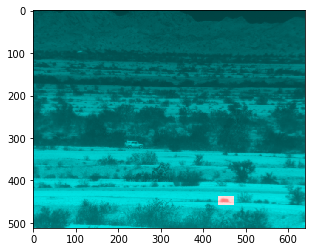

In [69]:
generator = generate_X(test_data,image_path=base_dir,batch_size=100,features =4,stats=stats)
x,y=next(generator)
gen_analysis(x)
#gen_analysis_1(x)
print(np.unique(y['output']))
plt.imshow(x['input'][0])

In [9]:
def create_model():
    #random.seed(seed_value)
    seed_value = 100
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value

    np.random.seed(seed_value)





    img_input = tf.keras.layers.Input(shape=(512,640,3),name="input")
    vgg16 = tf.keras.applications.xception.Xception(include_top=False,pooling ='max',
                                                    weights='imagenet', input_tensor=img_input, input_shape=(512,640,3))

    
    vgg_out = vgg16.output
    roi_input=tf.keras.layers.Input(shape=(number_of_bounding_boxes_per_frame,number_roi_features,),
                                    name='bounding_boxes', dtype='int32')


    local_object_context = tf.keras.layers.Input(shape=(4*local_feature_classes,),name='local_object_context')

    #global scene context
    global_scene_context = tf.keras.layers.Input(shape=(global_feature_classes,),name='global_scene_context')


    #range, confidence, time of day
    feature_count=0
    if bounding_box_range:
        feature_count+=1
    if bounding_box_conf:
        feature_count+=1
    if rangemap_box_range:
        feature_count+=1
    if y_position:
        feature_count+=1
    if wid_included:
        feature_count+=1
    if hgt_included:
        feature_count+=1
    if time_of_day:
        feature_count+=1 
    range_confidence = tf.keras.layers.Input(shape=(feature_count*number_of_bounding_boxes_per_frame,),name='range_confidence')

    #concatenate not equal to Concatenate
    merge_one = tf.keras.layers.Concatenate(axis=1)([local_object_context, global_scene_context])
    merge_two = tf.keras.layers.Concatenate(axis=1)([merge_one, range_confidence])
    #print(roi_output.shape)
    roi_out_flat  = tf.keras.layers.Flatten()(vgg_out)#(roi_output)
    roi_out_flat = tf.keras.layers.Dropout(drop)(roi_out_flat)
    merge_three = tf.keras.layers.Concatenate(axis=1)([merge_two,roi_out_flat])
    #merge_three = tf.keras.layers.Dropout(drop)(merge_three)
    dense_0 = tf.keras.layers.Dense(dense_neurons_layer1, activation='relu')(merge_three)
    dense_0 = tf.keras.layers.Dropout(drop)(dense_0)
    dense_1 = tf.keras.layers.Dense(dense_neurons_layer2, activation='relu')(dense_0) 
    dense_1 = tf.keras.layers.Dropout(drop)(dense_1)
    out = tf.keras.layers.Dense(1, activation='sigmoid',name='output')(dense_1)
    
    model = tf.keras.models.Model(inputs=[local_object_context]+[global_scene_context]
                                  +[range_confidence]+[img_input]+[roi_input], outputs=out)
    



    

    model_json = model.to_json()
    with open(model_path+model_name+"model.json", "w") as json_file:
        json_file.write(model_json)#'''
    #model.summary()
    return model


In [10]:
loss_function='binary_crossentropy'


#learning reate
learning_rate = 0.0004

#learning scedule
#epochs
epochs=50
#steps per epoch

batch_size =6
steps_per_epoch =650
validation_steps =160

class_weight = {0: 1.,
                1: 1.7
               }

drop=0.5
#dense_neurons_layer1 =500
dense_neurons_layer1 = 1100
#dense_neurons_layer1=1200
dense_neurons_layer2 =500
#number of channels per image
number_of_channels =1

#image processor
image_processor = "xception"#'vgg16' #options inception, ResNet

#add segmentation features
global_feature_classes=10
local_feature_classes=10

#ROI features
pool_height=4
pool_width=4
number_of_bounding_boxes_per_frame=1
number_roi_features=4

#add features
bounding_box_conf=True
bounding_box_range=False
rangemap_box_range=True
y_position=False
wid_included=True
hgt_included=True
time_of_day=False
model_name = 'gen_X_M_tf13_3'
from keras import backend as K

Using TensorFlow backend.


In [104]:
model=None
gc.collect()

model=create_model()


#print("Loaded model from disk")




#optimizer
#optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate, epsilon=1e-08, decay=0.0)
#optimizer = tf.keras.optimizers.Adadelta(lr=learning_rate, epsilon=1e-07, rho=0.95)
#optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
optimizer = tf.keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=loss_function, 
              metrics=['acc',tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC()])





logdir = "logs/p36_t13/" + datetime.now().strftime(model_name+"-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq= 'batch')

generator = generate_X(test_data,image_path=base_dir,batch_size=batch_size*steps_per_epoch,features =4,
                       bounding_box_range=False, y_position=False,stats=stats)
val_generator = generate_X(val_data,image_path=base_dir,batch_size=batch_size*validation_steps,features =4,
                           bounding_box_range=False, y_position=False,stats=stats)
val_x,val_y = next(val_generator)
lr_new = learning_rate
max_score = 0
stale_limit=2
global_stale_limit=9
slowdown = 0; global_slowdown=1
primary_metric = 'acc'
story=[]
for i in range(epochs):
    print('epoch: ',i)
    x=None; y=None


    
    
    x,y =next(generator)
    

    schedule_lr=tf.keras.callbacks.LearningRateScheduler(lambda x : lr_new, verbose=1)
    history = model.fit(x=x,y=y,batch_size=batch_size,validation_data=(val_x,val_y),
                                  epochs=1, callbacks=[schedule_lr],class_weight=class_weight ) 
                                  
        
        
    story.append(history.history)
    slowdown+=1; global_slowdown+=1
    #val_f1
    #2*val_pre*val_recall/(val_pre+val_recall)
    val_recall=history.history['val_recall'][0]
    val_precision=history.history['val_precision'][0]
    val_f1 = 2*val_recall*val_precision/(val_recall+val_precision)
    if val_f1+0.00002 > max_score:
        max_score=val_f1
        slowdown=0
        global_slowdown = 0
        model.save_weights(model_name+".h5")
        print("New top model")
    elif stale_limit <= slowdown :
        lr_new *= 0.6
        slowdown =0
    elif global_slowdown >global_stale_limit:
        print("stale score training ceased")
        break
#'''samples_per_epoch = batch_size * number_of_batches

length of an epoch 1.0
(1800,) int64
Generate one batch of data
0 1800 1.0
0 1800 1.0 960 (1800, 15)
0 1800 960 1.0 960 (1800, 15)
epoch:  0
length of an epoch 5.0
(20000,) int64
Generate one batch of data
0 20000 5.0
1 20000 5.0 3900 (20000, 15)
1 20000 3900 5.0 3900 (20000, 15)
Train on 3900 samples, validate on 960 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0004.
3900/3900 [==============================] - 1369s 351ms/sample - loss: 0.8815 - acc: 0.5418 - recall: 0.9322 - precision: 0.5269 - auc_3: 0.6458 - val_loss: 0.8022 - val_acc: 0.3292 - val_recall: 1.0000 - val_precision: 0.0345 - val_auc_3: 0.9303
New top model
epoch:  1
Generate one batch of data
1 20000 5.0
2 20000 5.0 3900 (20000, 15)
2 20000 3900 5.0 3900 (20000, 15)
Train on 3900 samples, validate on 960 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0004.
3900/3900 [==============================] - 1349s 346ms/sample - loss: 0.5669 - acc: 0.7841 - recall: 0.9162 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3900/3900 [==============================] - 1384s 355ms/sample - loss: 0.0626 - acc: 0.9856 - recall: 0.9924 - precision: 0.9794 - auc_3: 0.9968 - val_loss: 0.1019 - val_acc: 0.9656 - val_recall: 0.2174 - val_precision: 0.2500 - val_auc_3: 0.8894
epoch:  19
Generate one batch of data
4 20000 5.0
0 20000 5.0 3900 (20000, 15)
0 20000 3900 5.0 3900 (20000, 15)
Train on 3900 samples, validate on 960 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 1.86624e-05.
3900/3900 [==============================] - 1381s 354ms/sample - loss: 0.0545 - acc: 0.9851 - recall: 0.9934 - precision: 0.9774 - auc_3: 0.9981 - val_loss: 0.1020 - val_acc: 0.9708 - val_recall: 0.1739 - val_precision: 0.3077 - val_auc_3: 0.8902
epoch:  20
Generate one batch of data
0 20000 5.0
1 20000 5.0 3900 (20000, 15)
1 20000 3900 5.0 3900 (20000, 15)
Train on 3900 samples, validate on 960 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 1.86624e-05.
3900/3900 [=======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [105]:
#312020
story

[{'loss': [0.8815411591529846],
  'acc': [0.5417949],
  'recall': [0.9321519],
  'precision': [0.5269033],
  'auc_3': [0.64577174],
  'val_loss': [0.8022133968770504],
  'val_acc': [0.32916668],
  'val_recall': [1.0],
  'val_precision': [0.03448276],
  'val_auc_3': [0.9303281],
  'lr': [0.0004]},
 {'loss': [0.5669159047190959],
  'acc': [0.78410256],
  'recall': [0.9161954],
  'precision': [0.7240959],
  'auc_3': [0.8864971],
  'val_loss': [0.5151731270831078],
  'val_acc': [0.79895836],
  'val_recall': [1.0],
  'val_precision': [0.106481485],
  'val_auc_3': [0.96151],
  'lr': [0.0004]},
 {'loss': [0.3514501391000186],
  'acc': [0.90589744],
  'recall': [0.9297075],
  'precision': [0.88736534],
  'auc_3': [0.9549374],
  'val_loss': [0.1392637187265791],
  'val_acc': [0.9614583],
  'val_recall': [0.5217391],
  'val_precision': [0.31578946],
  'val_auc_3': [0.9413716],
  'lr': [0.0004]},
 {'loss': [0.25525370236199635],
  'acc': [0.9328205],
  'recall': [0.9569184],
  'precision': [0.914

In [74]:
story

[{'loss': [0.9695592214510991],
  'acc': [0.51974356],
  'recall': [0.9686076],
  'precision': [0.51369494],
  'auc': [0.5942357],
  'val_loss': [0.8963784821331501],
  'val_acc': [0.053125],
  'val_recall': [1.0],
  'val_precision': [0.024678111],
  'val_auc': [0.8369913],
  'lr': [0.0004]}]

In [76]:
model.save_weights(model_name+"last_run.h5")
#model.save("X_crwh_model1_avco11_filtered.hdf5")
#estimator = tf.keras.estimator.model_to_estimator(model) #config=config)

In [260]:
history.history
#results for model "X_crwh_model1_avco11_filtered.hdf5"
r1 ={'loss': [0.030037751084323994],
 'acc': [0.99128205],
 'recall_8': [0.99366087],
 'precision_8': [0.9884393],
 'auc_8': [0.9993584],
 'val_loss': [0.5643167757519223],
 'val_acc': [0.86354166],
 'val_recall_8': [0.72746783],
 'val_precision_8': [0.9883382],
 'val_auc_8': [0.9524291],
 'lr': [0.000144]}


{'loss': [0.030037751084323994],
 'acc': [0.99128205],
 'recall_8': [0.99366087],
 'precision_8': [0.9884393],
 'auc_8': [0.9993584],
 'val_loss': [0.5643167757519223],
 'val_acc': [0.86354166],
 'val_recall_8': [0.72746783],
 'val_precision_8': [0.9883382],
 'val_auc_8': [0.9524291],
 'lr': [0.000144]}

In [292]:
story

[{'loss': [0.7339367038699297],
  'acc': [0.6310256],
  'recall_8': [0.8359897],
  'precision_8': [0.592134],
  'auc_8': [0.7133098],
  'val_loss': [0.5245379731990397],
  'val_acc': [0.73854166],
  'val_recall_8': [0.4828326],
  'val_precision_8': [0.9574468],
  'val_auc_8': [0.9117088],
  'lr': [0.0004]},
 {'loss': [0.3512395814863535],
  'acc': [0.87846154],
  'recall_8': [0.9046653],
  'precision_8': [0.8618358],
  'auc_8': [0.9419159],
  'val_loss': [0.3576490167994052],
  'val_acc': [0.84375],
  'val_recall_8': [0.7081545],
  'val_precision_8': [0.9593023],
  'val_auc_8': [0.9634933],
  'lr': [0.0004]},
 {'loss': [0.25650579081776625],
  'acc': [0.91384614],
  'recall_8': [0.93193716],
  'precision_8': [0.8962739],
  'auc_8': [0.96799016],
  'val_loss': [0.5142405490856617],
  'val_acc': [0.78333336],
  'val_recall_8': [0.555794],
  'val_precision_8': [0.99615383],
  'val_auc_8': [0.9700419],
  'lr': [0.0004]},
 {'loss': [0.20594988470538877],
  'acc': [0.93333334],
  'recall_8':

In [108]:
import sys
tmp=[]
for var, obj in locals().items():
    tmp.append(( sys.getsizeof(obj), var))
tmp.sort(key = lambda x: x[0])
print(tmp[-10:])

[(7644, '_i6'), (7644, '_i17'), (7645, '_i18'), (7646, '_i19'), (2585892, 'val_data'), (7295976, 'verification_data'), (28515384, 'test_data'), (28515384, 'test_data_filtered'), (70282492, 'more_test_data'), (115748976, 'more_val_data')]


In [107]:
#test_data_filtered=0
#more_test_data=0
#more_val_data=0
#model=0
y_stack=0
x_values=0
x_bounding_box=0
x_filenames=0
x_framenumbers=0
y_ESRpred=0
y_ESRtrue=0
y_double_stack=0
val_df=0
results=0
#verification_data=0
#val_data_norm=0
#test_data_norm=0

In [11]:
stats ={'conf': [0.1818904590098017, 0.1181622865211339], 'rangemap': [2.7273172128683116, 4.709290451829926], 'range': [5.11838980756068, 1.6430380213772784], 'y': [0.6251205288353127, 0.22616891888414536], 'wid': [7.147089597113857, 8.12325808978054], 'Hgt': [1.986997394267456, 1.1321398953002695]}
#test data balanced avco11 all
def generate_X(list_IDs,batch_size=32,image_path=base_dir,features=4,channels=3,
               bounding_box_conf=True,bounding_box_range=False, rangemap_box_range=True, stats={},
                 y_position=False,wid_included=True,hgt_icluded=True,time_of_day=False, dim=(512,640)):
        'Generates data containing batch_size images'
        # Initialization
        channel=3
        len_epoch = np.floor(len(list_IDs) // batch_size) #'Denotes the number of batches per epoch'
        
        print("length of an epoch",len_epoch)
        indexes = np.arange(len(list_IDs))
        print(indexes.shape,indexes.dtype)
        np.random.shuffle(indexes)
        index=0    
        def _load_grayscale_image(image_path,chan = False, cv2_true = False, box=[], dim=dim):
            'Load grayscale image'

            if chan:
                image_preprocess = vgg1_preprocess_input(seg_img, rangemap,image_path, order='bw')
            elif cv2_true:
                'Load grayscale image'
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255
                image_preprocess = np.stack([img,img,img], axis=2)#.reshape(512,640,3)
            else:
                # convert the image pixels to a numpy array
                image_load = tf.keras.preprocessing.image.load_img(image_path, target_size=(dim[0],dim[1]))
                # convert the image pixels to a numpy array
                image_2_arr = tf.keras.preprocessing.image.img_to_array(image_load)
                # prepare the image for the VGG model
                image_preprocess = tf.keras.applications.vgg16.preprocess_input(image_2_arr)
            if box!=[]:
                min_pix, max_pix = [0,1]#[-123.68000030517578, 151.06100463867188]
                image_preprocess[:,:,0] = create_mask(min_pix, max_pix, box, dim)
                
            return  image_preprocess
        def normalize_batch(ID,stats,feature):
            stat=stats[feature]
            return (ID[feature]-stat[0])/float(stat[1])
            
        while True:
            print('Generate one batch of data')
            print(index,len(indexes),len_epoch)
            # Generate indexes of the batch
            index+=1
            if index>= len_epoch:
                index=0
                np.random.shuffle(indexes)
            indexes_temp = indexes[index*batch_size: (index+1)*batch_size]
            print(index,len(indexes),len_epoch,batch_size,list_IDs.shape)
            # Find list of IDs
            list_IDs_temp = [list_IDs.iloc[k] for k in indexes_temp]
            print(index,len(indexes),len(list_IDs_temp),len_epoch,batch_size,list_IDs.shape)
            #generate data arrays
            local_object_features= np.empty((batch_size, 40),dtype='float32')
            globalFeatures = np.empty((batch_size, 10),dtype='float32')
            range_confidence = np.empty((batch_size, features),dtype='float32')
            original_feature = np.empty((batch_size, 6),dtype='float32')
            bounding_boxes = np.empty((batch_size, 4),dtype='float32')
            image = np.empty((batch_size, 512, 640, channels),dtype='float32')     
            labels = np.empty((batch_size, 1), dtype=int)
            filenames =[]
            framenumbers =  []
            '''
            ['filename','framenumber','boundboxIndex','bbox#',"labels",'conf','rangemap','range','y','range_confidence',
                   'wid','Hgt','bounding_boxes', 'local_object_context', 'global_scene_context']
            '''
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                #frnm = ID['framenums']
                #bboxes=ID['bboxes']
                #name = ID['filenames']
                labels[i,] = 1 if ID['labels'] else 0
                local_object_features[i,] = np.array(ID['local_object_context'].copy(),dtype='float32')
                globalFeatures[i,] = np.array(ID[ 'global_scene_context'].copy(),dtype='float32')
                hand_features=[]
                if bounding_box_conf:
                    hand_features.append(normalize_batch(ID,stats,'conf'))
                if bounding_box_range:
                     hand_features.append(normalize_batch(ID,stats,'range'))
                if rangemap_box_range:
                    hand_features.append(normalize_batch(ID,stats,'rangemap'))
                if y_position:
                    hand_features.append(normalize_batch(ID,stats,'y'))
                if wid_included:
                     hand_features.append(normalize_batch(ID,stats,'wid'))
                if hgt_icluded:
                     hand_features.append(normalize_batch(ID,stats,'Hgt'))
                if time_of_day:
                     hand_features.append(normalize_batch(ID,stats,'time'))
                range_confidence[i,] = np.array(hand_features,dtype='float32').copy()
                original_feature[i,] = np.array(ID['range_confidence'].copy())
                bounding_boxes[i,] = get_bounding_box(ID['bounding_boxes'],1,dim)
                filenames.append(ID['filename'])
                framenumbers.append(ID['framenumber'])
                # Store sample
                image[i,] = _load_grayscale_image(get_avi_dir(ID['filename'], ID['framenumber'], image_path),
                                                 cv2_true = True,box = ID['bounding_boxes'])


            #return X
            inpts={}
            inpts['filename']=np.array(filenames).reshape(-1,1)
            inpts['framenumber']=np.array(framenumbers).reshape(-1,1)
            inpts['local_object_context']=local_object_features
            inpts['global_scene_context']=globalFeatures
            inpts['range_confidence']=range_confidence
            inpts['input']=image
            inpts['original_features']= original_feature
            inpts['bounding_boxes']=bounding_boxes.reshape((batch_size,1,4))
            
            yield inpts, {'output': labels.reshape((batch_size,1))}
            
#get_avi_dir(ID['filename'], ID['framenumber'], image_path)
#filename
#frame

In [22]:

import sklearn.metrics as metrics

def get_any_results(arr, feature='conf'):

    results = pd.DataFrame(data=arr,  columns=['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','filename','framenumber','x1','y1','x2','y2']) 
    cols = ['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','framenumber','x1','y1','x2','y2']
    results[cols] = results[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    return results
def best_results(results, lvl, feature='conf'):
    stat_counts = {"TN":[0,0],"FP":[0,1],"TP":[1,1],"FN":[1,0],}
    def digi(x):return 1 if x>lvl else 0
    def f(prediction,label,val=[0,0]):
            return 1 if prediction==val[1] and label==val[0] else 0
    results['prediction'] = results['pred_val'].map(digi)
    for key, val in stat_counts.items():
        results[key] = results[['prediction','label']].apply(lambda x: f(*x,val=val), axis=1)
        #holder = results[1 if (results['predictions']==val[0]) & (results['label']==val[1]) else 0]
        #results[key]=holder
    return results
def bayesian_criterion(results):
    y_true = results['label'].to_numpy()
    y_conf = results['conf'].to_numpy()
    y_pred = results['pred_val'].to_numpy()
    #calculate ROC
    fpr, tpr, thresh = metrics.roc_curve(y_true,y_conf)
    esr_fpr, esr_tpr, esr_thresh = metrics.roc_curve(y_true, y_pred)
    print("Baseline results")
    def get_cutoff(true_counts, tpr, fpr,thresh):
        bc=[]
        for i in range(len(fpr)):
            criterion = tpr[i]*true_counts[1]
            criterion -= fpr[i]*true_counts[0]
            bc.append([criterion,thresh[i],tpr[i],fpr[i],tpr[i]*true_counts[1],fpr[i]*true_counts[0]])
        return max(bc, key=lambda x:x[0])
    true_counts = np.unique(results['label'],return_counts=True)[1]
    lvl = get_cutoff(true_counts, tpr, fpr,thresh)
    print(lvl)
    y_conf_pred = [1 if conf > lvl[1] else 0 for conf in y_conf]
    print(sum(y_conf_pred))
    print( 'false positive', true_counts[0],'true positive',true_counts[1])
    
    lvl = get_cutoff(true_counts, esr_tpr, esr_fpr,esr_thresh)
    print(lvl)
    y_predictions=[1 if conf > lvl[1] else 0 for conf in y_pred]
    print(sum(y_predictions))

    print(metrics.classification_report(y_true,y_conf_pred))
    print('ESR results')
    print(metrics.classification_report(y_true, y_predictions))
    fig, ax = plt.subplots()
    #ax.scatter( thresh,fpr)
    #ax.scatter( thresh,tpr)
    ax.scatter( fpr,tpr, label="no ESR")
    ax.scatter( esr_fpr,esr_tpr, label="with ESR")
    #ax.scatter( tpr,fpr)
    ax.set_xlim([0, 1])
    ax.set_xlabel('false positive rate of predictions\nwith score >= thresholds')
    ax.set_ylabel('true positive rate of predictions\nwith score >= thresholds')
    ax.legend()
    plt.title('ROC Curve')
    plt.savefig("ROC.jpg", format='jpg')
    return best_results(results, lvl[1])


In [13]:
factors=['conf','rangemap','range','y','wid','hgt','time','pred_val']
factors=['conf','rangemap','range','y','wid','hgt','time','pred_val']
def analyze_factor_panda(results,factor,factors=factors,bins=20,x=[1,10,6,1,20,10,1]):
    name=factor
    
    stat_counts = {"ff":[0,0],"ft":[0,1],"ff":[1,1],"tf":[1,0],}
    stat_counts = {"TN":[0,0],"FP":[0,1],"TP":[1,1],"FN":[1,0],}
    conf_ = {key:results.loc[results[key]==1,[factor]].to_numpy() for key,value in stat_counts.items()}
    

    
    
    factor=factors.index(factor)

    print(' TP ',len(conf_['TP']),' FN ',len(conf_['FN']),' TN ',len(conf_['TN']),' FP ',len(conf_['FP']))
    
    x=x[factor]
    hist = {key:np.histogram(value,bins=bins,range=(0,x)) for key, value in conf_.items()}
    #shist ={key:sum(val[0]) for key,val in hist.items()}
    print( name + " Recall"  , np.divide(hist["TP"],np.add(np.add(hist["TP"],hist['FN']),0.0000001))[0])
    #print( name + "Precision"  ,hist["TP"]/(hist["TP"]+hist['FP']+0.0000001))
    #print( name + "Accuracy"  ,(hist["TP"]+hist['TN'])/(hist["TP"]+hist['TN']+hist['FP']+hist['FN'])+0.0000001)
    #print(name + "False Positive" ,hist['FP']/(hist['FP']+hist['TN']+0.0000001))
    #print(name + "Miss Rate" ,hist['FN']/(hist['FN']+hist['TN']+0.0000001))
    
    factors=['Confidence','range from map in thousands ','predicted range in thousands','y %','wid','hgt','time %']
    Other_factors=['Confidence level','Range (from Range Map) in Thousands ','Predicted Range','Y %','Bounding Box Width','Bounding Box Height','time %']
    name =factors[factor]
    '''print( " Recall"  ,shist["TP"]/(shist["TP"]+shist['FN']+0.0000001))
    print("Precision"  ,shist["TP"]/(shist["TP"]+shist['FP']+0.0000001))
    print("Accuracy"  ,(shist["TP"]+shist['TN'])/(sum(list(shist.values()))+0.0000001))
    print("False Positive" ,shist['FP']/(shist['FP']+shist['TN']+0.0000001))
    print("Miss Rate" ,shist['FN']/(shist['FN']+shist['TN']+0.0000001))'''
    
    plt.figure(1,figsize=(20,10))
    plt.subplot(131)
    
    plt.hist([conf_['TN'],conf_['FP']],label = ["predicted False","predicted True"], stacked=True,bins=bins,)
             #range=(0,x))
    plt.title('Statistics for False Positive')
    plt.legend()
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    #plt.show()
    #print(len(conf_ff),len(conf_ft))
    plt.savefig(name+"FalsePositivedataset_val.jpg", format='jpg')

    #plt.figure()
    plt.subplot(132)
    plt.hist([conf_["TP"],conf_['FN']],label = ["predicted True","predicted False"], stacked=True,bins=bins,)#range=(0,x))
    plt.title('Statistics for True Positive ')
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    plt.legend(    )
    #plt.show()
    plt.savefig(name+"_TruePositivesdataset_val.jpg", format='jpg')
    
    plt.subplot(133)
    plt.hist([conf_["TP"],conf_['FP']],label = ["True Target","Not a Target"], stacked=True,bins=bins,)#range=(0,x))
    plt.title(Other_factors[factor]+"for True Positives\n balanced 1 channel dataset")
    plt.xlabel(factors[factor])
    plt.ylabel('Counts')
    plt.legend(    )
    plt.savefig(name+"_PredictedTruePositivesdataset_val.jpg", format='jpg')

In [14]:
verification_data = pd.read_pickle(base_dir+'data/raw_validation_py2_pds.pkl')
print_features(verification_data)
print(len(verification_data['filename']))
print(len(np.unique(verification_data['filename'])))
#print(len(more_test_data['filename']))
#print(len(np.unique(more_test_data['filename'])))
#print(np.unique(more_test_data['filename']))
np.unique(len(verification_data['filename']))

min and max   conf (0.51, 0.0)  rangemap (3.578, 0.528)  range (5.999, 0.756)  y (0.978515625, 0.40625)  wid (62.4, 0.7)  Hgt (10.9, 0.5)
total length of validation data 5400
5400
6


array([5400])

0    0.42
Name: conf, dtype: object
length of an epoch 54.0
(5400,) int64
Generate one batch of data
0 5400 54.0
1 5400 54.0 100 (5400, 15)
1 5400 100 54.0 100 (5400, 15)
range_confidence
-1.5393275022506714 7.696047782897949
global_scene_context
0.0 0.8479911684989929
local_object_context
0.0 1.0
bounding_boxes
7.0 631.0
input
0.0 1.0
[0]
[  8. 272.  18. 282.]


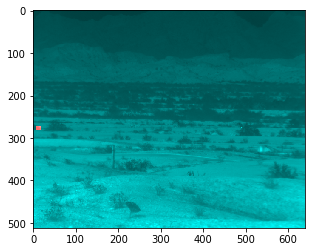

In [15]:
print(verification_data['conf'].head(1))
generator = generate_X(verification_data,image_path=base_dir,batch_size=100,features =4,stats=stats)
x,y=next(generator)
gen_analysis(x)
#gen_analysis_1(x)
print(np.unique(y['output']))
plt.imshow(x['input'][0])
print(x['bounding_boxes'][0][0])

(3, 2)


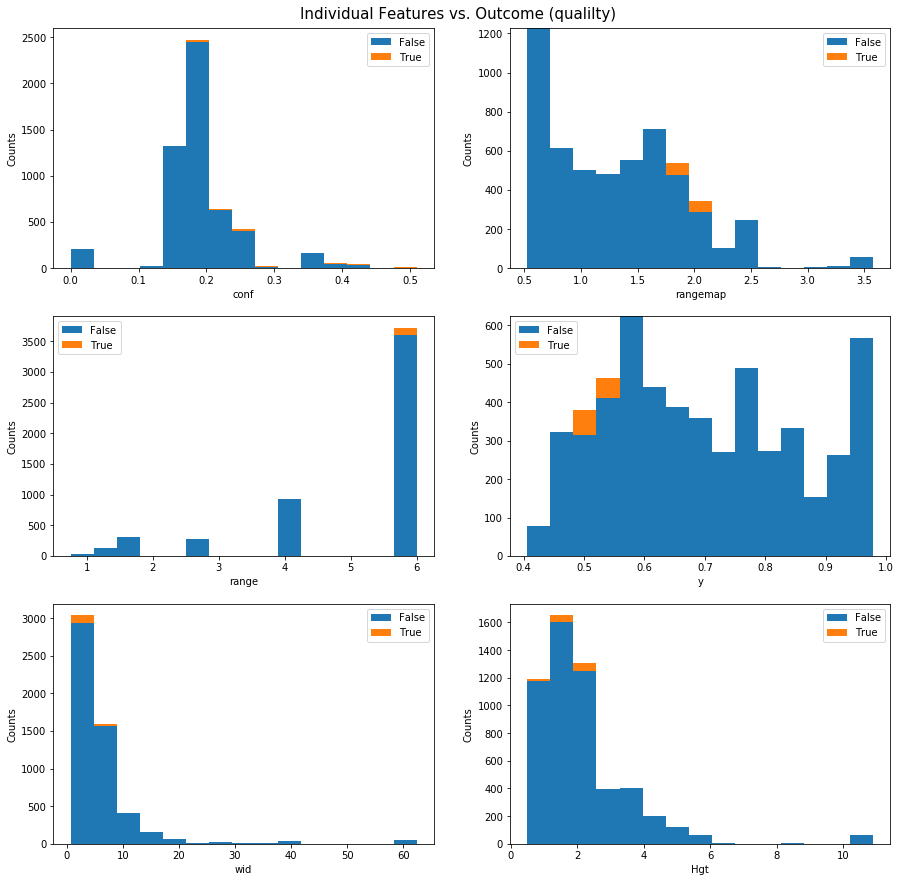

None

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
col_analysis=['labels', 'conf',
       'rangemap', 'range', 'y', 'wid', 'Hgt']
feature_EDA1(verification_data,subscript="_verification")

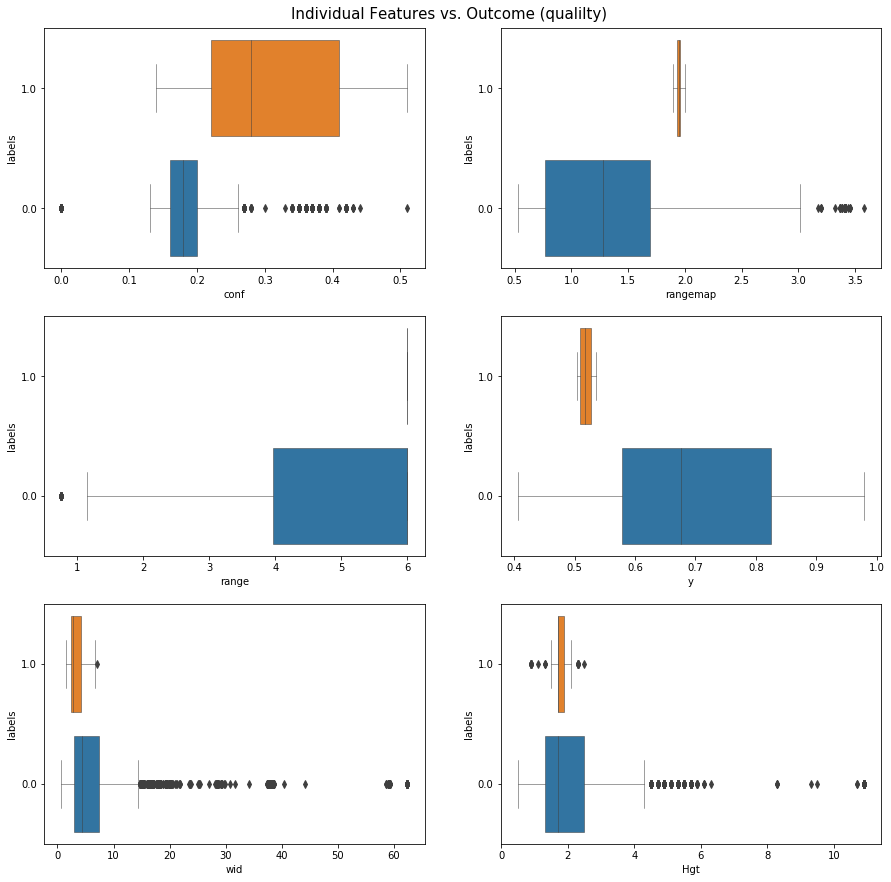

None

In [17]:
feature_EDA2(verification_data,subscript="_verification")

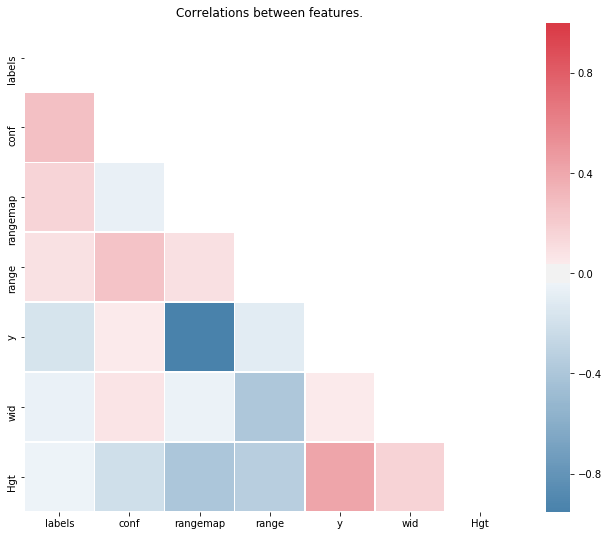

None

In [18]:
feature_EDA3(verification_data,subscript="_verification")

In [12]:
#verification_data_norm =  normalize(gauss_normalize,stats,column_names,verification_data.copy())

In [19]:
#model=None
#gc.collect()
model=create_model()
model.load_weights(model_name+'.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
verification_data_norm=None
data_len=len(verification_data['labels'])
#print(data_len)
#data_len =len(sample_df)
print('actual data length',data_len)

number_batches=4
generator = generate_X(verification_data,image_path=base_dir,batch_size=data_len//number_batches,features =4,stats=stats)
y_ESRpred=[];
y_ESRtrue=[];
x_values=[];x_filenames=[];x_framenumbers=[];x_bounding_box=[]
for i in range(number_batches):

    x,y=next(generator)
    predictions_val=model.predict(x=x, verbose=1)
    y_ESRpred.extend(predictions_val)
    y_ESRtrue.extend(y['output'])
    x_values.extend(x['original_features'])
    x_filenames.extend(x['filename'])
    x_framenumbers.extend(x['framenumber'])
    x_bounding_box.extend(x['bounding_boxes'])
    #print(len(y_ESRpred),len( y_ESRtrue),len(x_values)
y_ESRpred=np.array(y_ESRpred)
y_ESRtrue=np.array(y_ESRtrue)
y_stack=np.hstack((y_ESRtrue,y_ESRpred))
print(y_stack[0])
x_values = np.array(x_values)
print(x_values.shape,y_stack.shape)
y_double_stack=np.hstack((y_stack,x_values))
y_double_stack=np.hstack((y_double_stack,x_filenames))
y_double_stack=np.hstack((y_double_stack,x_framenumbers))
y_double_stack=np.hstack((y_double_stack,np.array(x_bounding_box).reshape(-1,4)))
print(y_double_stack.shape)
np.save('predictions_good2.npy',y_double_stack)

actual data length 5400
length of an epoch 4.0
(5400,) int64
Generate one batch of data
0 5400 4.0
1 5400 4.0 1350 (5400, 15)
1 5400 1350 4.0 1350 (5400, 15)
1350/1350 [==============================] - 101s 75ms/sample
Generate one batch of data
1 5400 4.0
2 5400 4.0 1350 (5400, 15)
2 5400 1350 4.0 1350 (5400, 15)
1350/1350 [==============================] - 92s 68ms/sample
Generate one batch of data
2 5400 4.0
3 5400 4.0 1350 (5400, 15)
3 5400 1350 4.0 1350 (5400, 15)
1350/1350 [==============================] - 92s 68ms/sample
Generate one batch of data
3 5400 4.0
0 5400 4.0 1350 (5400, 15)
0 5400 1350 4.0 1350 (5400, 15)
1350/1350 [==============================] - 92s 68ms/sample
[0.        0.0015209]
(5400, 6) (5400, 2)
(5400, 14)


In [ ]:
'''y_true = results['label'].to_numpy()
    y_conf = results['conf'].to_numpy()
    y_pred = results['pred_val'].to_numpy()
    print("Baseline results")
    y_predictions=results['prediction']
    y_conf_pred = [1 if conf > lvl else 0 for conf in y_conf]
    
def sum_type type='TP')
def get_any_results(arr, lvl, feature='conf'):
    stat_counts = {"TN":[0,0],"FP":[0,1],"TP":[1,1],"FN":[1,0],}
    results = pd.DataFrame(data=arr,  columns=['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','filename','framenumber','x1','y1','x2','y2']) 
    cols = ['label','pred_val','conf','rangemap','range','y',
                   'wid','Hgt','framenumber','x1','y1','x2','y2']
    results[cols] = results[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    def digi(x):return 1 if x>lvl else 0
    def f(prediction,label,val=[0,0]):
            return 1 if prediction==val[1] and label==val[0] else 0
    results['prediction'] = results['pred_val'].map(digi)
    for key, val in stat_counts.items():
        results[key] = results[['prediction','label']].apply(lambda x: f(*x,val=val), axis=1)
        #holder = results[1 if (results['predictions']==val[0]) & (results['label']==val[1]) else 0]
        #results[key]=holder
    return results'''

(5400, 14)
(5400, 14)
Baseline results
[20.999999999999996, 0.4000000059604645, 0.37398373983739835, 0.004737540269092288, 46.0, 25.000000000000004]
64
false positive 5277 true positive 123
[30.0, 0.6358652710914612, 0.45528455284552843, 0.004927041879855979, 56.0, 26.0]
81
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5277
         1.0       0.61      0.32      0.42       123

    accuracy                           0.98      5400
   macro avg       0.80      0.66      0.70      5400
weighted avg       0.98      0.98      0.98      5400

ESR results
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5277
         1.0       0.68      0.45      0.54       123

    accuracy                           0.98      5400
   macro avg       0.83      0.72      0.77      5400
weighted avg       0.98      0.98      0.98      5400



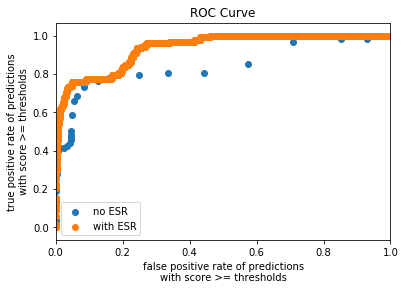

In [24]:

#our best point on the roc curve beats their best point on the roc curve.
print(y_double_stack.shape)
results1 = get_any_results(y_double_stack)
print(results1.shape)
print
results = bayesian_criterion(results1)

 TP  55  FN  68  TN  5251  FP  26
pred_val Recall [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.33333332 0.99999998 0.99999998 0.99999999 0.99999998 0.99999999
 0.99999999 0.99999999]


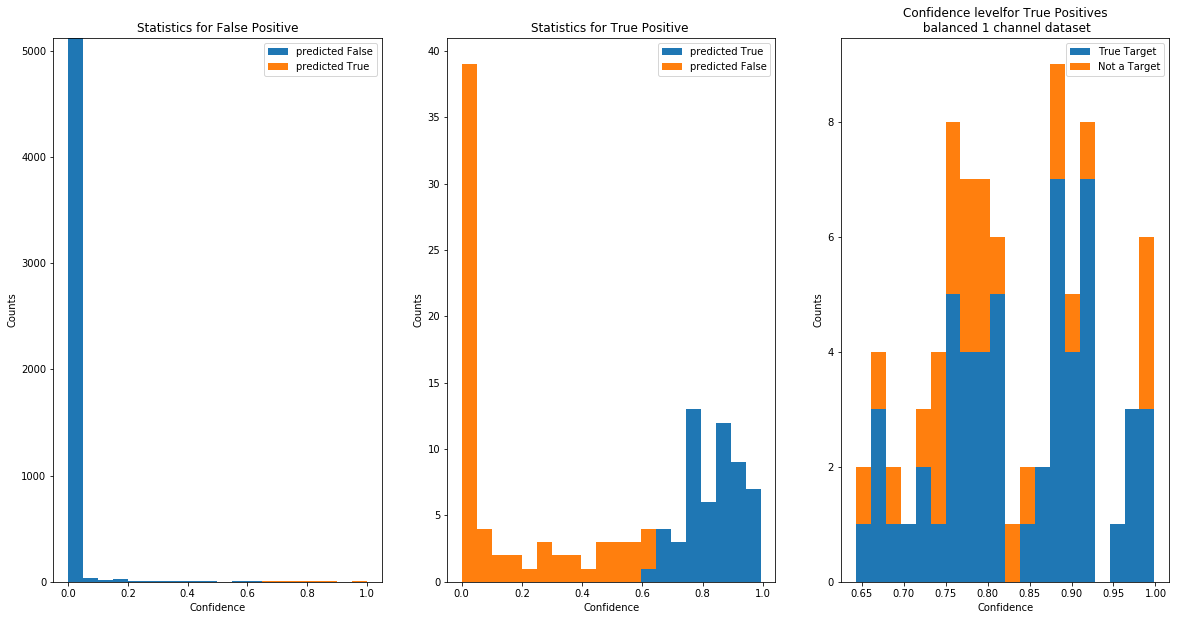

In [25]:
factors=['conf','rangemap','range','y','wid','hgt','time','pred_val']
factor='pred_val'
analyze_factor_panda(results,factor, factor,bins=20, x=[1,10,6,1,20,10,1])

 TP  55  FN  68  TN  5251  FP  26
conf Recall [0.         0.         0.04       0.54054054 0.25       0.45714286
 0.99999999 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


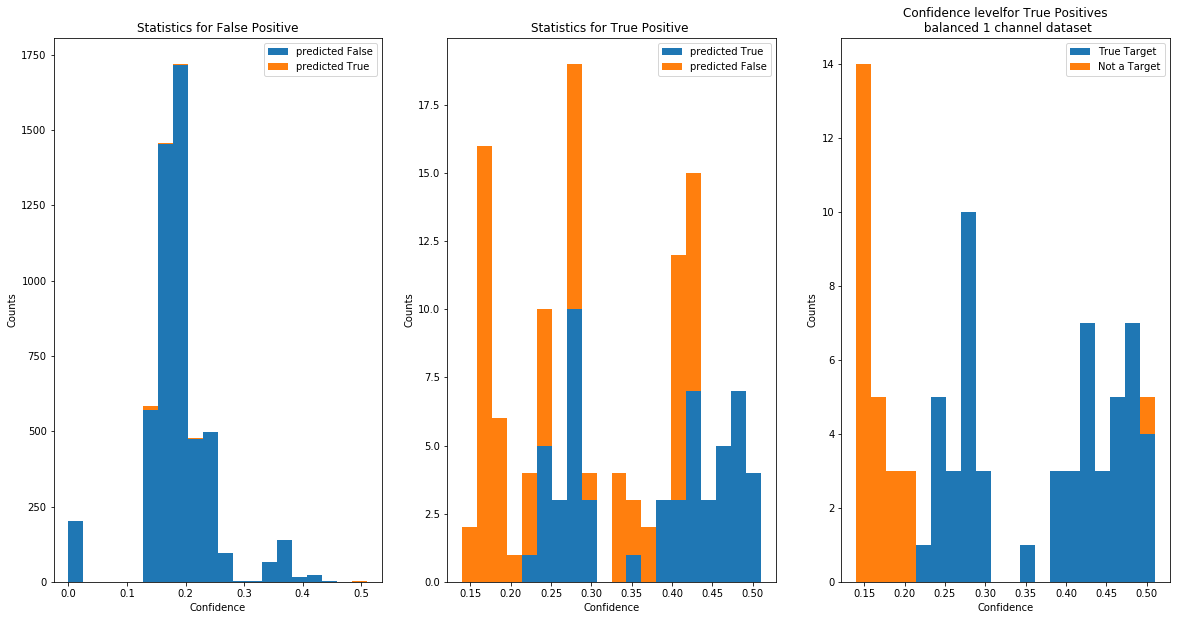

In [26]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='conf'
analyze_factor_panda(results,factor, factor,x=[1.5,10,6,1,20,10,1])

 TP  55  FN  68  TN  5251  FP  26
rangemap Recall [0.         0.44715447 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


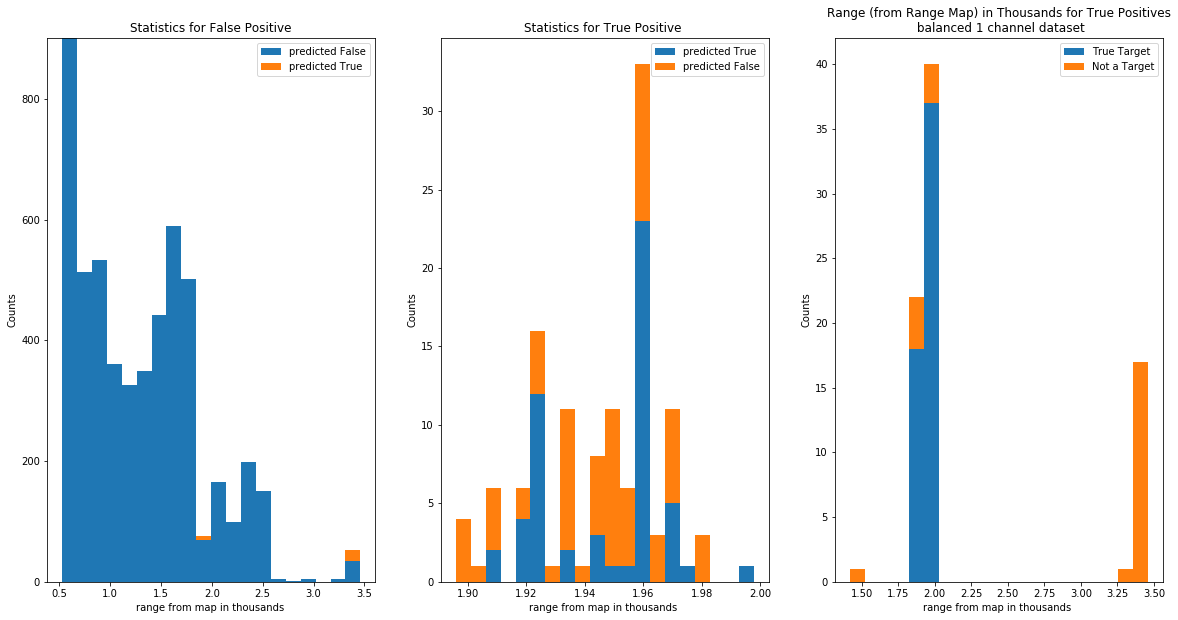

In [27]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='rangemap'
x=[1.5,30,6,1,20,10,1]
analyze_factor_panda(results, factor,x=x)

 TP  85  FN  38  TN  5090  FP  187
wid Recall [0.         0.74698795 0.99999999 0.33333333 0.         0.
 0.         0.         0.         0.        ]


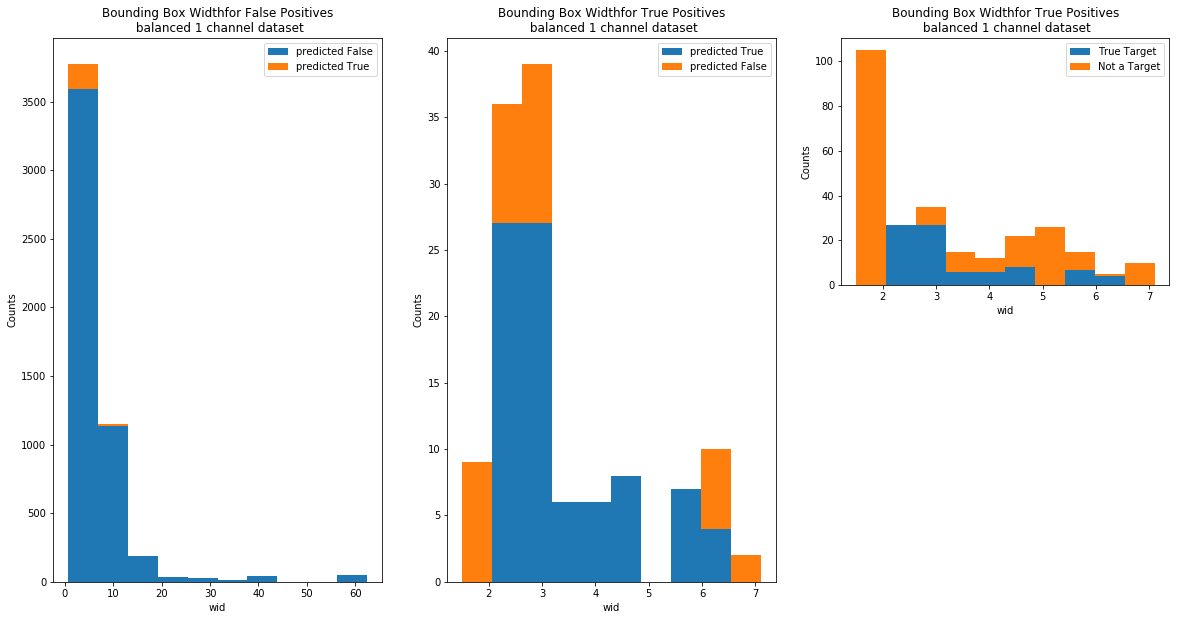

In [92]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='wid'
analyze_factor_panda(results, factor)

 TP  85  FN  38  TN  5090  FP  187
Hgt Recall [0.         0.70731707 0.87096774 0.         0.         0.
 0.         0.         0.         0.        ]


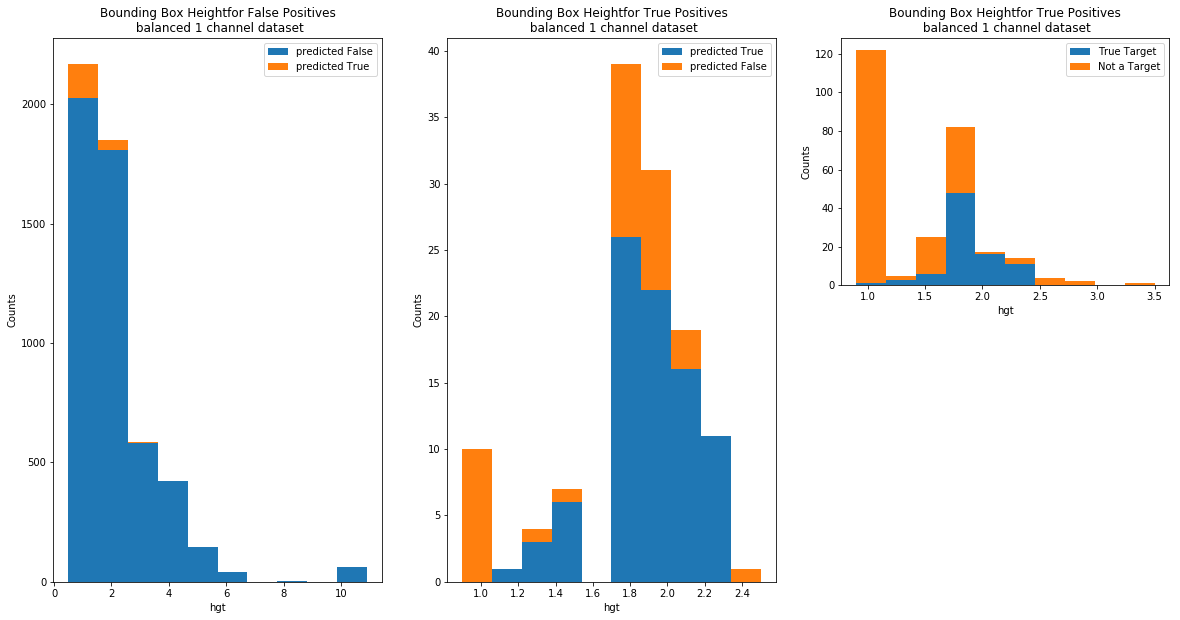

In [93]:
factors=['conf','rangemap','range','y','wid','Hgt','time']
factor='Hgt'
analyze_factor_panda(results,factor,  factors=factors)

 TP  85  FN  38  TN  5090  FP  187
y Recall [0.         0.         0.         0.         0.         0.69105691
 0.         0.         0.         0.        ]


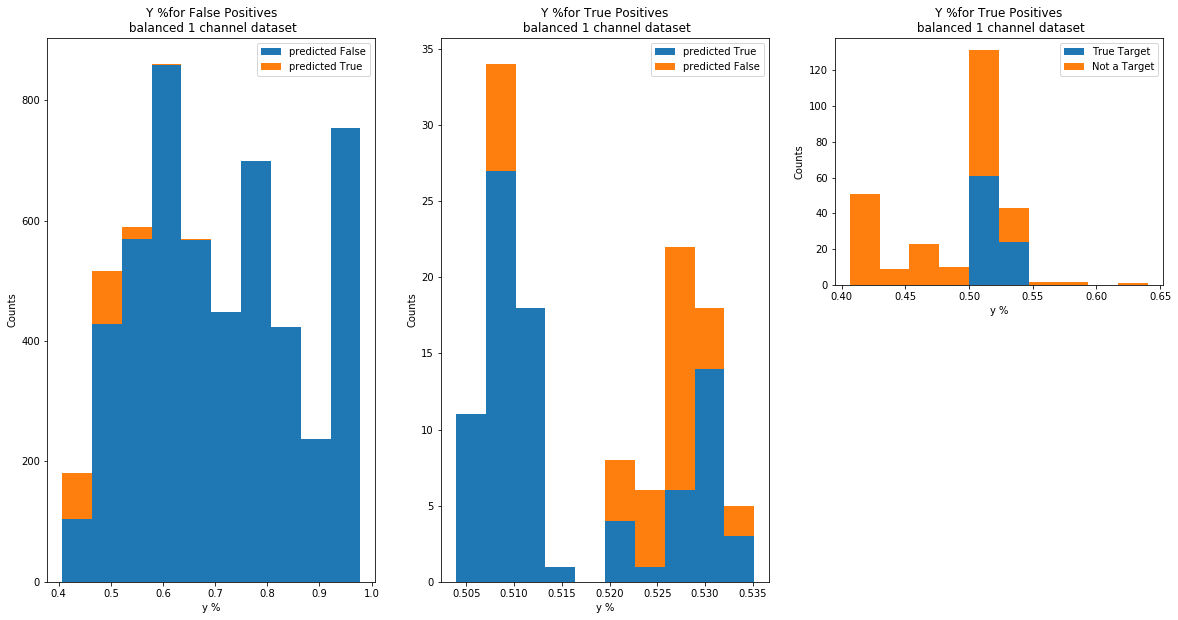

In [94]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='y'
analyze_factor_panda(results,factor, bins=10)

 TP  85  FN  38  TN  5090  FP  187
range Recall [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.69105691]


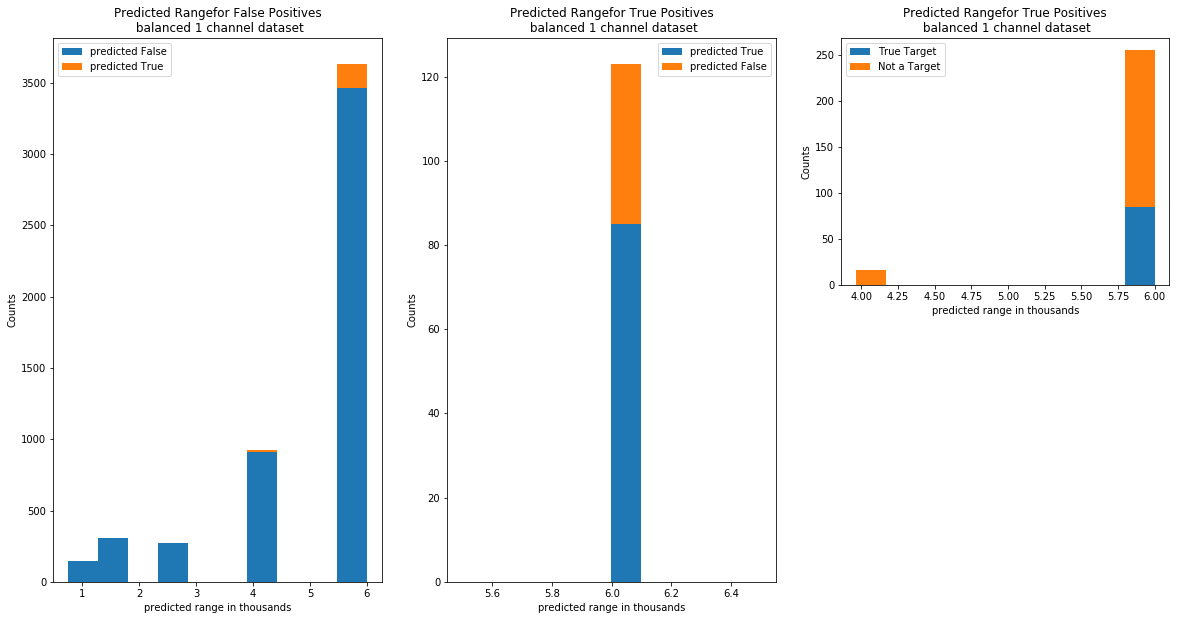

In [95]:
factors=['conf','rangemap','range','y','wid','hgt','time']
factor='range'
analyze_factor_panda(results,factor,)

In [39]:
def get_avi_dir(name, frmnum, base_dir):
    return base_dir+"multi_frame_captures/"+name+'/'+name+"_frame"+str(frmnum)+'.png'
def get_ARF_dir(name, base_dir):    
    return base_dir+'semantic/'+name+'/'+name+'_000000_ARF.png'
def select_color(bpred,label,colors):
    x=[bpred,label]
    if x[1]==0 and x[0]==0:
        return colors[0]
    if x[1]==0 and x[0]==1:
        return colors[1]
    if x[1]==1 and x[0]==1:
        return colors[2]
    if x[1]==1 and x[0]==0:
        return colors[3]
def eval_pred(thresh,pred):
    return 1 if pred>thresh else 0

def test_images_data(data, base_dir,output_directory,long_count=2,thresh=.5):
    make_directory= "test_images/"+output_directory
    !mkdir -p {make_directory}
    data = data[['filename','framenumber','x1','y1','x2','y2',"labels",'conf']]
    print(data.head(3))
    col_dict={"blue":(200,0,0),"green":(0,200,0),'red':(0,0,200),'yellow':(0,200,200)}
    colors=[(200,0,0),(0,200,0),(0,0,200),(0,200,200)]
    image_count=0;    prev_filename=None; prev_frame=None; count=0;
    first=True
    for i,line in data.iterrows():
        #print(type(line))
        if image_count>4:
                break
        if line['filename']!=prev_filename or line['framenumber'] != prev_frame:
            if False:
               cv2.imwrite(make_directory+"/"+str(line['filename'])+"_"+str(line['framenumber'])+".jpg",image) 

            try:
                cv2.imwrite(make_directory+"/"+str(line['filename'])+"_"+str(line['framenumber'])+".jpg",image)
            except:
                pass
            
            image_count+=1
            print('new image',line['filename'], line['framenumber'])
            
            image = cv2.cvtColor(cv2.imread(get_avi_dir(line['filename'], line['framenumber'], base_dir)), cv2.COLOR_BGR2GRAY)
            count=0
        #wid (62.4, 0.7)  Hgt (17.1, 0.5)
        out=[]; #count=1;
        count+=1
        out.append([int(line['labels']),int(line['conf'])*100])
        #box=line['bounding_boxes']
        cv2.putText(image,
                    str(box[0])+', '+str(int(line['labels']))+", "+str(int(line['conf']*100)),
                    (int(box[1]),int(box[2]-4))
                    ,0,0.3,(20,20,20))
        rect_color=select_color(eval_pred(thresh,.52),int(line['labels']),colors)
        
        cv2.rectangle(image,(int(line['x1']),int(line['y1'])),(int(line['x2']),int(line['y2'])),rect_color,2)
        prev_filename =line['filename']
        prev_frame = line['framenumber']
            





In [40]:

def test_images_df(data, base_dir,output_directory,name,fnumb,thresh=.5):
    make_directory= base_dir+"test_images/"+output_directory
    !mkdir -p {make_directory}
    data = data[['filename','framenumber','x1','y1','x2','y2',"label",'conf','prediction']]
    #print(data.head(3))
    col_dict={"blue":(200,0,0),"green":(0,200,0),'red':(0,0,200),'yellow':(0,200,200)}
    colors=[(200,0,0),(0,200,0),(0,0,200),(0,200,200)]
    color_lbls=["Tgt:T,Pred:T-RED;"," Tgt:T,Pred:F-YLW;","Tgt:F,Pred:T-GRE;","Tgt:F,Pred:F-BLU"]
    bounding_box_key="Bounding Box label: Index, True label, POC Conf "

    image = cv2.cvtColor(cv2.imread(get_avi_dir(name, str(fnumb), base_dir)), cv2.COLOR_BGR2GRAY)
    for i,line in data[(data['filename']==name) & (data['framenumber']==fnumb)].iterrows():

        out=[]; #count=1;
        out.append([int(line['label']),int(line['conf'])*100])
        box=line[['x1','y1','x2','y2']].to_numpy()
        cv2.putText(image,
                    str(int(line['label']))+", "+str(int(line['conf']*100)),
                    (int(box[0]),int(box[1]-4))
                    ,0,0.3,(20,20,20))
        #rect_color=select_color(eval_pred(thresh,.52),int(line['label']),colors)
        
        cv2.rectangle(image,(int(line['x1']),int(line['y1'])),(int(line['x2']),int(line['y2'])),
                      select_color(line['prediction'],line['label'],colors),2)
    cv2.imwrite(make_directory+'/'+name+"_evalution_.jpg",image)

In [41]:
output_dir='trial5'
ok=['avco12221_0001','avco13221_1001','avco13221_1002','avco13221_2001','avco13221_2002','avco13221_3001']
for name in ok:
    test_images_df(results, base_dir,output_dir,name,10,thresh=.5)